In [2]:

import torch
# from tbparse import SummaryReader
from functools import partial
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
from adjustText import adjust_text
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})


# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

## function development

In [3]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
    "Bio_ClinicalBERT": "Bio-ClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
    "biobert-v1.1": "BioBERT",
    "Llama-2-7b-hf": "Llama-2-7b",
    "bert-base-uncased": "BERT-base",
    "distilbert-base-uncased": "DistilBERT-base",
    "google/mobilebert-uncased": "MobileBERT",
    "prajjwal1/bert-tiny": "TinyBERT",
    }

# task name mappings

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",
                      "ICD9-Triage": "ICD9-Triage"}

def get_configs(logs_dir, modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(f"{logdir}/", extra_columns={'dir_name'})
    df = reader.scalars
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(
        lambda x: partial(get_configs, logdir)(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')

    # we want to replace few_shot_n nan values with few_shot_n = "full"
    # check if few_shot_n is a column
    if "few_shot_n" in merged_df.columns:
        merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))

    # now map to a more suitable name
    merged_df["Model name"] = merged_df["Model name"].replace(long_model_name_mappings)
    
    
    return merged_df

In [159]:
# def get_trainer_args(modeldir):
#     with open(logdir + modeldir + '/all_trainer_args.yaml') as f:
#         trainer_args= yaml.load(f, Loader=yaml.FullLoader)
#         trainer_args['dir_name'] = modeldir
#     return trainer_args

### Get number of trainable parameters for each model type



In [4]:
with open('../trainable_params.yaml', 'r') as f:
    trainable_params_mapping = yaml.load(f, yaml.FullLoader)

with open('../model_type_trainable_model_size.yaml', 'r') as f:
    model_type_size_mappings = yaml.load(f, yaml.FullLoader)

with open('../gpu_memory_needed.json', 'r') as f:
    gpu_memory_needed = yaml.load(f, yaml.FullLoader)

In [4]:
list(trainable_params_mapping.keys())

['/mnt/sdc/niallt/saved_models/declutr/mimic/few_epoch/mimic-roberta-base/2_anch_2_pos_min_1024/transformer_format/',
 '/mnt/sdc/niallt/saved_models/language_modelling/mimic/mimic-roberta-base/sampled_250000/22-12-2022--12-45/checkpoint-100000/',
 '/mnt/sdc/niallt/saved_models/language_modelling/mimic/roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted/sampled_250000/07-07-2023--08-30/checkpoint-30000/',
 'dmis-lab/biobert-v1.1',
 'emilyalsentzer/Bio_ClinicalBERT',
 'meta-llama/Llama-2-7b-hf',
 'michiyasunaga/BioLinkBERT-base',
 'michiyasunaga/LinkBERT-base',
 'nlpie/bio-mobilebert',
 'nlpie/distil-biobert',
 'nlpie/tiny-biobert',
 'roberta-base']

In [5]:
trainable_params_mapping["roberta-base"]

{'Full': {'full_model_size_GB': 0.9287792639806867,
  'full_model_size_MB': 951.0699663162231,
  'model_size_GB': 0.46434689313173294,
  'model_size_MB': 475.49121856689453,
  'n_peft_params': 124055040,
  'n_peft_params_perc': 99.524955119318,
  'peft_full_model_size_GB': 0.9287792639806867,
  'peft_full_model_size_MB': 951.0699663162231,
  'peft_model_size_GB': 0.46434689313173294,
  'peft_model_size_MB': 475.49121856689453,
  'total_params': 124647170},
 'IA3': {'full_model_size_GB': 0.9287792639806867,
  'full_model_size_MB': 951.0699663162231,
  'model_size_GB': 0.46434689313173294,
  'model_size_MB': 475.49121856689453,
  'n_peft_params': 64512,
  'n_peft_params_perc': 0.05175568767425686,
  'peft_full_model_size_GB': 0.9287792639806867,
  'peft_full_model_size_MB': 951.0699663162231,
  'peft_model_size_GB': 0.46434689313173294,
  'peft_model_size_MB': 475.49121856689453,
  'total_params': 124647170},
 'LORA': {'full_model_size_GB': 0.9287792639806867,
  'full_model_size_MB': 951

In [4]:
gpu_memory_needed

{'nlpie/bio-mobilebert': 0.09157848358154297,
 'nlpie/tiny-biobert': 0.05176830291748047,
 'roberta-base': 0.46604251861572266,
 'nlpie/distil-biobert': 0.24604511260986328,
 'dmis-lab/biobert-v1.1': 0.40447139739990234,
 'meta-llama/Llama-2-7b-hf': 24.739288330078125}

### debugging

In [7]:
logdir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars


In [7]:
config_list = df["dir_name"].drop_duplicates().apply(lambda x: partial(get_configs, logdir)(x))
config_df = pd.DataFrame.from_records(config_list)
df = pd.merge(df, config_df, on='dir_name')

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/ICD9-Triage/full/distil-biobert/Full/17-11-2023--21-51/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/ICD9-Triage/full/distil-biobert/IA3/17-11-2023--21-31/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/distil-biobert/Full/17-11-2023--21-55/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/distil-biobert/IA3/17-11-2023--21-34/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-los/full/distil-biobert/Full/17-11-2023--21-50/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-los/full/distil-biobert/IA3/17-11-2023--21-30/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/sa

In [8]:
df.peft_method.value_counts()

LORA             31080
Full             25164
IA3              25164
PREFIX_TUNING    23310
PROMPT_TUNING    19284
Name: peft_method, dtype: int64

## Load in events files



In [5]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'
logs_df = read_tb_files(logs_dir)

  0%|          | 0/221 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--15-56/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--17-58/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--18-13/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base_declutr_2_anch_2_pos_min_1024/LORA/22-12-2023--18-14/config.yaml'


  0%|          | 0/143052 [00:00<?, ?it/s]

### investigate files

In [7]:
logs_df.head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,299,eval/accuracy,0.925498,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
1,598,eval/accuracy,0.940912,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
2,897,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
3,1196,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
4,1495,eval/accuracy,0.949261,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert


In [8]:
logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'custom_model_name', 'data_dir', 'dropout',
       'early_stopping_patience', 'early_stopping_threshold',
       'eight_bit_training', 'eval_batch_size', 'eval_data_dir',
       'eval_every_steps', 'eval_few_shot_n', 'evaluation_strategy',
       'fast_dev_run', 'few_shot_n', 'label_col', 'label_name',
       'learning_rate', 'loader_workers', 'log_every_steps', 'log_save_dir',
       'lora_alpha', 'lora_dropout', 'lora_rank', 'max_epochs', 'max_length',
       'metric_mode', 'model_name_or_path', 'monitor', 'n_trainable_params',
       'no_cuda', 'num_virtual_tokens', 'optimizer', 'optuna', 'patience',
       'peft_method', 'pretrained_models_dir', 'remove_columns',
       'save_adapter', 'save_every_steps', 'saving_strategy', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget', 'train_batch_size', 'training_data_dir', 'training

In [5]:
logs_df.model_name_or_path.unique()

array(['nlpie/bio-mobilebert', 'dmis-lab/biobert-v1.1',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'nlpie/tiny-biobert',
       'nlpie/tiny-clinicalbert', 'bert-base-uncased',
       'prajjwal1/bert-tiny', 'distilbert-base-uncased',
       'google/mobilebert-uncased', 'roberta-base'], dtype=object)

In [10]:
logs_df["Model name"].unique()

array(['bio-mobilebert', 'BioBERT', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [11]:
# check unique tasks 
logs_df.task.value_counts()

task
i2b2-2014-NER    33255
mimic-mp         25110
mimic-los        22590
i2b2-2010-RE     16875
ICD9-Triage       7920
i2b2-2012-NER     5715
i2b2-2010-NER     5670
Name: count, dtype: int64

In [12]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'eval/f1', 'test/f1'], dtype=object)

In [13]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250])

In [15]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,299,eval/accuracy,0.925498,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
1,598,eval/accuracy,0.940912,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
2,897,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
3,1196,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
4,1495,eval/accuracy,0.949261,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115517,5310,test/f1_macro,0.472474,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115518,5310,test/f1_micro,0.895642,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115519,5310,test/f1_weighted,0.846336,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115521,5310,test/precision,0.447821,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert


In [16]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name


## Pull out metrics etc

In [6]:
def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                     
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df.loc[logs_df['tag'].str.contains('|'.join(metrics))]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

In [6]:
# metrics_df = extract_metric(logs_df, mode = "eval", metrics = ["f1","accuracy"], sample_sizes = [999], save_csv = False)

In [7]:
# metrics_df.task_type.unique()

In [7]:
def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "mean",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        # tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"eval/",'')
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"test/",'')
        
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

Below will retrieve all metrics of choice for each task and return the max

In [8]:
cls_results_df = produce_results_table(logs_df, 
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

In [21]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
      dtype=object)

In [22]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype='object', name='tag')

In [28]:
cls_results_df["Model name"].unique()

array(['BERT-base', 'Bio-ClinicalBERT', 'BioBERT', 'DistilBERT-base',
       'RoBERTa-base', 'TinyBERT_General_4L_312D', 'bio-mobilebert',
       'clinical-distilbert', 'clinical-mobilebert', 'distil-biobert',
       'mobilebert-uncased', 'tiny-biobert', 'tiny-clinicalbert'],
      dtype=object)

### trainable_params_mapping

In [9]:
trainable_params_mapping['roberta-base']['LORA'].keys()

dict_keys(['full_model_size_GB', 'full_model_size_MB', 'model_size_GB', 'model_size_MB', 'n_peft_params', 'n_peft_params_perc', 'peft_full_model_size_GB', 'peft_full_model_size_MB', 'peft_model_size_GB', 'peft_model_size_MB', 'total_params'])

In [10]:
cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('total_params', np.NaN), axis=1)
cls_results_df['full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('model_size_GB', np.NaN), axis=1)
cls_results_df['full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('model_size_MB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['peft_method'], {}).get('peft_model_size_MB', np.NaN), axis=1)


In [25]:
cls_results_df.head(3)

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,0.946406,0.947013,0.874629,0.947013,...,1160.397217,41.188000,1.288,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765


In [21]:
# below doesn't handle mappings with no values
# cls_results_df['PEFT_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['n_peft_params'], axis=1)
# cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['n_peft_params_perc'], axis=1)
# cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['total_params'], axis=1)

In [10]:
# cls_results_df.loc[
#     cls_results_df['few_shot_n'] > 200].sort_values(
#                                         ['task', 'f1_macro'], 
#                                         ascending=[True, False]).head(20)

In [11]:
# get remaining NER
ner_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                        task_type = "TOKEN_CLS",
                                        value_aggregate_method = "max",
                                        )

In [121]:
ner_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,Full,0.930603,0.947615,0.857877,0.856037,0.864545,0.821867,0.821637,0.822097
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,IA3,0.830793,0.847326,0.454201,0.464756,0.444115,0.471903,0.499843,0.446920
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,LORA,0.905475,0.923514,0.732703,0.748841,0.717246,0.713018,0.730265,0.696567
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,PREFIX_TUNING,0.818223,0.838363,0.445300,0.464257,0.427831,0.453597,0.493298,0.419810
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,Full,0.906669,0.914063,0.848851,0.842254,0.859592,0.823431,0.809410,0.837946
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,IA3,0.795349,0.795515,0.481382,0.485276,0.477551,0.488838,0.491421,0.486283
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,LORA,0.887448,0.896688,0.786780,0.780399,0.796735,0.756664,0.747420,0.766138
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,PREFIX_TUNING,0.774790,0.773346,0.443478,0.450000,0.437143,0.445669,0.450759,0.440694
8,8,BioBERT,dmis-lab/biobert-v1.1,i2b2-2014-NER,250,Full,0.996772,0.996574,0.964678,0.966003,0.968151,0.968502,0.971618,0.965406
9,9,BioBERT,dmis-lab/biobert-v1.1,i2b2-2014-NER,250,IA3,0.986155,0.986531,0.848464,0.852794,0.844178,0.849201,0.857696,0.840873


## Get pending tasks

In [29]:
# import datasets.yaml
import yaml
with open('../datasets.yaml', 'r') as f:
    dataset_mapping = yaml.load(f, yaml.FullLoader)

In [12]:
# print keys of dataset
list(dataset_mapping.keys())

['mednli',
 'mimic-dia',
 'mimic-dia-adm-only',
 'mimic-los',
 'mimic-los-adm-only',
 'mimic-mp',
 'ICD9-Triage',
 'i2b2-2010-NER',
 'i2b2-2012-NER',
 'i2b2-2014-NER',
 'i2b2-2010-RE']

In [21]:
cls_results_df.query("task == 'i2b2-2010-RE'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,Full,0.937744,0.676479,0.937744,0.937263,...,1395.907349,79.719002,2.493,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,IA3,0.893930,0.283517,0.893930,0.876678,...,1165.987549,95.438004,2.985,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,LORA,0.924116,0.404030,0.924116,0.916927,...,1188.701416,93.614998,2.928,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,PREFIX_TUNING,0.868140,0.161255,0.868140,0.817965,...,1096.670410,101.471001,3.173,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,PROMPT_TUNING,0.853651,0.102339,0.853651,0.786254,...,1147.976196,96.935997,3.031,7680,0.007091,108311810,0.403493,413.176765,0.403493,413.176765
24,24,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,Full,0.929349,0.530681,0.929349,0.925223,...,1210.822754,91.903999,2.874,24581888,99.995826,24582914,0.091578,93.776375,0.091578,93.776375
25,25,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,IA3,0.896721,0.297467,0.896721,0.880790,...,1109.573120,100.291000,3.136,58368,0.237433,24582914,0.091578,93.776375,0.091578,93.776375
26,26,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,LORA,0.918442,0.419853,0.918442,0.910261,...,1230.920654,90.403999,2.827,221184,0.899747,24582914,0.091578,93.776375,0.091578,93.776375
27,27,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,PROMPT_TUNING,0.853651,0.103397,0.853651,0.786514,...,941.981018,118.134003,3.694,1280,0.005207,24582914,0.091578,93.776375,0.091578,93.776375
39,39,distil-biobert,nlpie/distil-biobert,i2b2-2010-RE,250.0,Full,0.928512,0.555458,0.928512,0.927032,...,1165.526978,95.475998,2.986,65783040,99.997662,65784578,0.245067,250.948250,0.245067,250.948250


In [30]:
from itertools import combinations, product, chain

In [31]:
# find all combinations of models, tasks , pefts using itertools combinations

# def cartesian_product(*arr):
#     # product of all pairwise combinations
#     # of the input arrays
#     res = arr[0]
#     for i in range(1, len(arr)):
#         res = list(product(res, arr[i]))
        
#     return [r[0]+(r[1],) for r in res]

def cartesian_product(*arr):
    if len(arr) == 0:
        return []
    if len(arr) == 1:
        return [tuple([i]) for i in arr[0]]
    sub_product = cartesian_product(*arr[1:])
    return [(x,)+y for y in sub_product for x in arr[0]]
        
    # return res
    # return the list of all the computed tuple
    # using the product() method
    # return list(product(arr1, arr2))

def get_remaining_experiments(results_df:pd.DataFrame,
                              get_few_shot:bool = False):
    
    # get all the experiments that have been run
    # get all the combinations of models, tasks, pefts
    # get all the combinations of models, tasks, pefts that have been run
    # get the difference between the two sets
    # return the difference    
    
    # also get fewshot tasks if required
    if get_few_shot:
        cols = ["model_name_or_path", "task", "peft_method", "few_shot_n"]
    else:
        cols = ["model_name_or_path", "task", "peft_method"]
        # only get the full training set 
        results_df = results_df[results_df["few_shot_n"] == 250]
    
    arr = []
    for c in cols:
        arr.append(results_df[c].unique())
    
    combos = cartesian_product(*arr)
    
    new_df = results_df.set_index(cols)
    print(f"new_df.index.to_list(): {new_df.index.to_list()}")
    pending_tasks = set(combos).difference(set(new_df.index.to_list()))
    print(f'Pending tasks before subsetting: {len(pending_tasks)}')
    
    return pending_tasks, cols

### manual approach if no experiments have been run yet

In [32]:
# create list of possible peft methods, models and tasks
# models = ["google/mobilebert-uncased",
#           "huawei-noah/TinyBERT_General_4L_312D",
#           "distilbert-base-uncased",
#           "emilyalsentzer/Bio_ClinicalBERT",
#           "bert-base-uncased",
#           ]

models = ["nlpie/bio-distilbert-uncased"]

# clinical models

# models = ["nlpie/clinical-mobilebert",
#           "nlpie/tiny-clinicalbert",
#           "nlpie/clinical-distilbert",]

# can subset tasks we want to look at here - at moment 01/12/23 we only need to run NER tasks as we have all the CLS tasks
tasks = [
        'mimic-los',
        'mimic-mp',
        'ICD9-Triage',
        'i2b2-2010-NER',
        'i2b2-2012-NER',
        'i2b2-2014-NER',
        'i2b2-2010-RE'
        ]
pefts = ["LORA", "Full"] 

### approach if experiments have been run

In [73]:


models = cls_results_df["Model name"].unique()
tasks = cls_results_df["task"].unique()
pefts = cls_results_df["peft_method"].unique()
few_shot_ns = cls_results_df["few_shot_n"].unique()
len(models), len(tasks), len(pefts), len(few_shot_ns)

(13, 4, 4, 1)

In [15]:
models, tasks

(array(['BioBERT', 'bio-mobilebert', 'distil-biobert', 'tiny-biobert'],
       dtype=object),
 array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
       dtype=object))

In [ ]:
# get all combinations of models, tasks, pefts and few_shot_ns

### for manual creation

In [33]:
# for manual creation
cols = ["model_name_or_path", "task", "peft_method"]
pending_tasks = cartesian_product(models, tasks, pefts)
pending_tasks = pd.DataFrame(pending_tasks, columns=cols)

In [34]:
pending_tasks.shape

(14, 3)

In [35]:
# save all to file
pending_tasks

,model_name_or_path,task,peft_method
0,nlpie/bio-distilbert-uncased,mimic-los,LORA
1,nlpie/bio-distilbert-uncased,mimic-mp,LORA
2,nlpie/bio-distilbert-uncased,ICD9-Triage,LORA
3,nlpie/bio-distilbert-uncased,i2b2-2010-NER,LORA
4,nlpie/bio-distilbert-uncased,i2b2-2012-NER,LORA
5,nlpie/bio-distilbert-uncased,i2b2-2014-NER,LORA
6,nlpie/bio-distilbert-uncased,i2b2-2010-RE,LORA
7,nlpie/bio-distilbert-uncased,mimic-los,Full
8,nlpie/bio-distilbert-uncased,mimic-mp,Full
9,nlpie/bio-distilbert-uncased,ICD9-Triage,Full


In [36]:
pending_tasks.to_csv("../training_bash_scripts/all_pending_tasks.csv", index=False, header=False)

### for automatic creation

In [74]:
pending_tasks, cols = get_remaining_experiments(cls_results_df)
pending_tasks = pd.DataFrame.from_records(list(pending_tasks), 
                        columns=cols)
pending_tasks.sort_values(cols, inplace=True)

pending_tasks = pending_tasks.loc[~(
                    pending_tasks['model_name_or_path'].str.contains('llama') |
                    pending_tasks['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks['model_name_or_path'].str.contains('Longformer') |
                    pending_tasks['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks['model_name_or_path'].str.contains('michiyasuna') 
                    )] 

pending_tasks = pending_tasks.loc[(pending_tasks['peft_method'] != "P_TUNING")]
# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks = pending_tasks.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & peft_method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks)}')

pending_tasks.head()

new_df.index.to_list(): [('bert-base-uncased', 'ICD9-Triage', 'Full'), ('bert-base-uncased', 'ICD9-Triage', 'LORA'), ('bert-base-uncased', 'i2b2-2010-RE', 'Full'), ('bert-base-uncased', 'i2b2-2010-RE', 'LORA'), ('bert-base-uncased', 'mimic-los', 'Full'), ('bert-base-uncased', 'mimic-los', 'LORA'), ('bert-base-uncased', 'mimic-mp', 'Full'), ('bert-base-uncased', 'mimic-mp', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-los', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-los', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-mp', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-mp', 'LORA'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'Full'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'IA3'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'LO

,model_name_or_path,task,peft_method
8,bert-base-uncased,ICD9-Triage,IA3
6,bert-base-uncased,ICD9-Triage,PREFIX_TUNING
83,bert-base-uncased,i2b2-2010-RE,IA3
19,bert-base-uncased,i2b2-2010-RE,PREFIX_TUNING
54,bert-base-uncased,mimic-los,IA3


In [18]:
pending_tasks

,model_name_or_path,task,peft_method


In [38]:
print(pending_tasks.shape)
pending_tasks.to_csv('../training_bash_scripts/pending_tasks_SEQ_CLS.csv', 
                        index=False, header=False)

(35, 3)


In [33]:
# get results where model name = RoBERTa-mimic-note-two-epoch
ner_results_df.query("`Model name` == 'RoBERTa-mimic-note-two-epoch'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1,precision,recall
39,39,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,250.0,LORA,0.934720,0.791830,0.788909,0.797723
40,40,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,250.0,LORA,0.905031,0.807471,0.787674,0.828288
41,41,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2014-NER,250.0,LORA,0.996631,0.964474,0.962493,0.970588


In [19]:
ner_results_df.peft_method.unique()

array(['LORA'], dtype=object)

In [20]:
# same as above but for NER results df
pending_tasks_ner, cols_ner = get_remaining_experiments(ner_results_df)
pending_tasks_ner = pd.DataFrame.from_records(list(pending_tasks_ner), 
                        columns=cols_ner)
pending_tasks_ner.sort_values(cols_ner, inplace=True)

pending_tasks_ner = pending_tasks_ner.loc[~(
                    pending_tasks_ner['model_name_or_path'].str.contains('llama') |
                    pending_tasks_ner['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('Longformer') |
                    # pending_tasks_ner['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks_ner['model_name_or_path'].str.contains('michiyasuna') |
                    pending_tasks_ner['model_name_or_path'].str.contains('johngiorgi/declutr-base') |
                    pending_tasks_ner['model_name_or_path'].str.contains('sentence-transformers/all-mpnet-base-v2') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('emilyalsentzer/Bio_ClinicalBERT')
                    )]
print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['peft_method'] != "P_TUNING")]
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['peft_method'] != "PREFIX_TUNING")]

# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks_ner = pending_tasks_ner.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & peft_method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')

pending_tasks_ner.head()

new_df.index.to_list(): [('nlpie/distil-biobert', 'i2b2-2010-NER', 'LORA')]
Pending tasks before subsetting: 0
Pending tasks after subsetting: 0
Pending tasks after subsetting: 0


,model_name_or_path,task,peft_method


In [36]:
pending_tasks_ner

,model_name_or_path,task,peft_method
47,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2010-NER,IA3
63,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2012-NER,IA3
64,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2014-NER,IA3
48,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,IA3
56,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,IA3
52,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2014-NER,IA3
37,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,Full
7,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,IA3
44,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,Full
10,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,IA3


In [32]:
pending_tasks_ner.peft_method.unique()

array(['Full', 'IA3', 'LORA'], dtype=object)

In [37]:
print(pending_tasks_ner.shape)
pending_tasks_ner.to_csv('../training_bash_scripts/pending_tasks_TOKEN_CLS.csv', 
                        index=False, header=False)

(12, 3)


## Plots

In [15]:
metric_name_mapping = { "f1_macro": "F1 macro",
                   "f1_micro": "F1 micro",
                   "f1": "F1",
                   "f1_weighted": "F1 weighted",
                    "roc_auc_macro": "ROC AUC",}


In [16]:
# set plotting save path
save_path = "/mnt/sdd/efficient_ml_data/figures_and_plots/"

### Sequence Classification

#### Peft method plot - Sequence Classification

In [12]:
cls_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BERT-base,bert-base-uncased,mimic-mp,250.0,Full,0.894319,0.652344,0.615752,0.652344,...,3514.627197,48.304001,1.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,BERT-base,bert-base-uncased,mimic-mp,250.0,LORA,0.900428,0.562500,0.458937,0.562500,...,2918.722900,58.166000,1.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,Full,0.946406,0.947013,0.874629,0.947013,...,1160.397217,41.188000,1.288,108310272.0,99.998580,108311810.0,0.403493,413.176765,0.403493,413.176765
3,3,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512.0,0.059561,108311810.0,0.403493,413.176765,0.403493,413.176765
4,4,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912.0,0.272281,108311810.0,0.403493,413.176765,0.403493,413.176765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,tiny-biobert,nlpie/tiny-biobert,mimic-los,250.0,PREFIX_TUNING,0.378311,0.366431,0.134083,0.366431,...,516.727905,294.362000,9.202,24960.0,0.179895,13874762.0,0.051688,52.928017,0.051688,52.928017
64,64,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,Full,0.896355,0.901793,0.611587,0.901793,...,795.619385,213.380997,6.674,13874136.0,99.995488,13874762.0,0.051688,52.928017,0.051688,52.928017
65,65,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,IA3,0.895642,0.894458,0.472145,0.894458,...,608.969116,278.782990,8.720,8544.0,0.061579,13874762.0,0.051688,52.928017,0.051688,52.928017
66,66,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,LORA,0.895642,0.894458,0.472145,0.894458,...,603.383789,281.363007,8.800,39936.0,0.287832,13874762.0,0.051688,52.928017,0.051688,52.928017


In [17]:
# peft_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
peft_methods_to_plot = ['PREFIX_TUNING', 'IA3', 'LORA', 'Full']
# for now we have hard coded the "full" training to be few_shot_n = 250...
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert', "BioBERT"
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]

plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

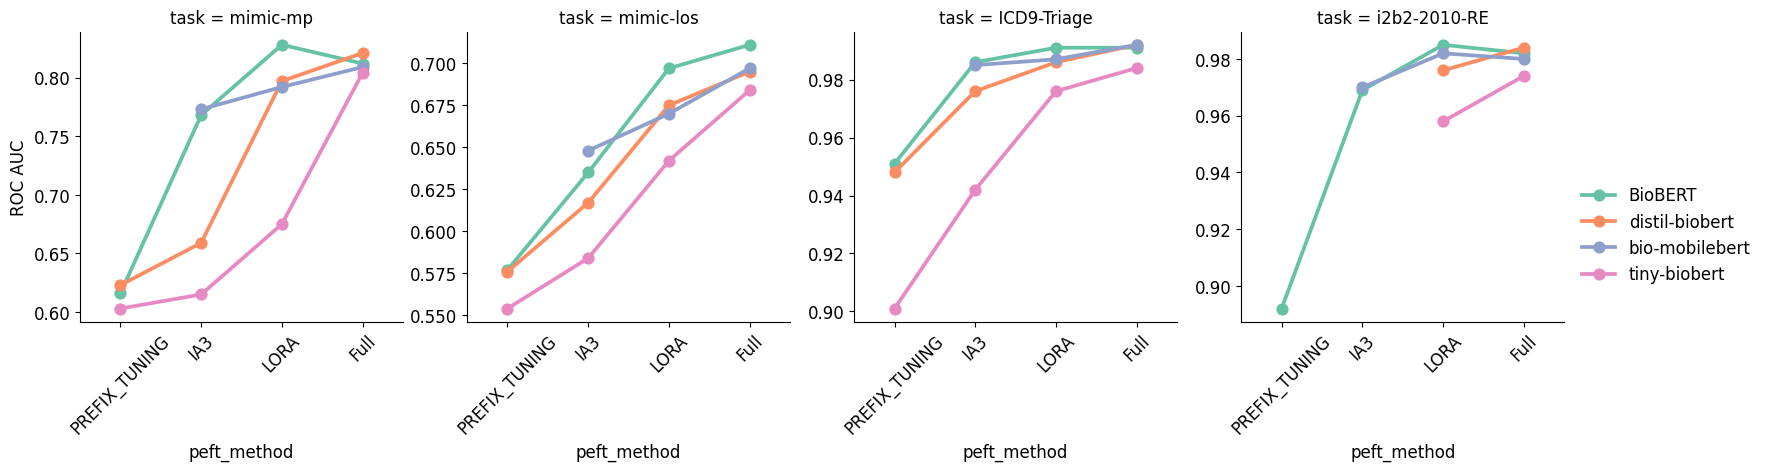

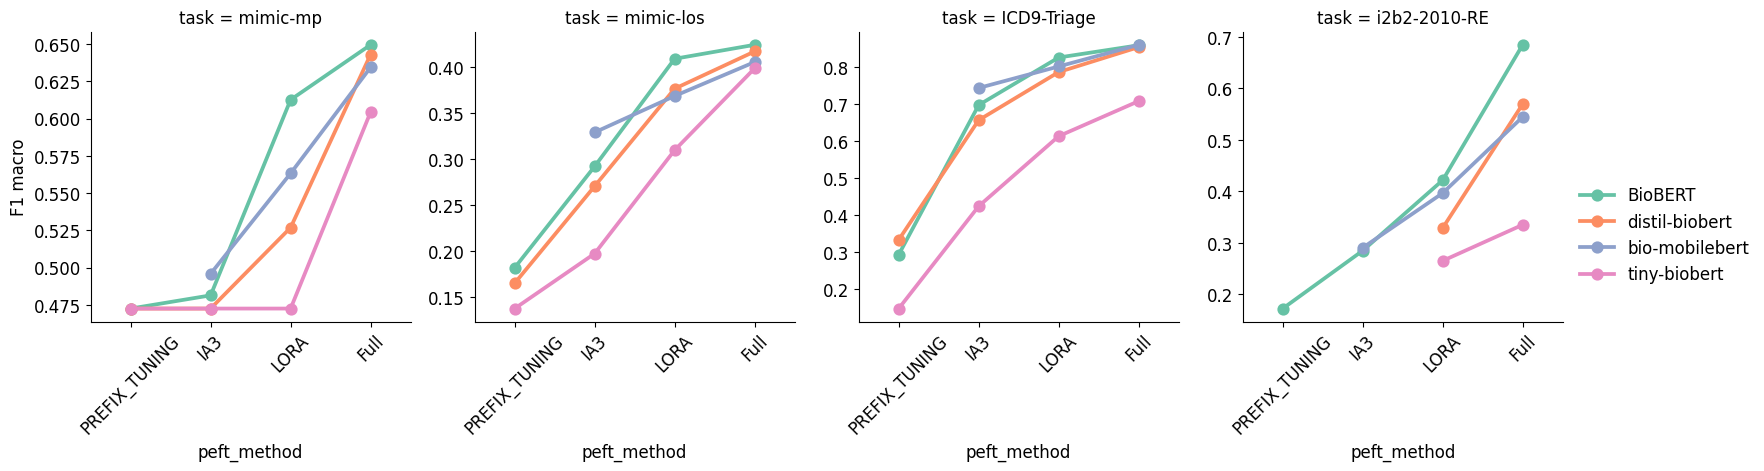

In [18]:


metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='Model name', 
                    order=peft_methods_to_plot, 
                    hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # set y label based on metric mapping
    fg.set_ylabels(metric_name_mapping[metric])
    plt.savefig(f'{save_path}/{metric}_peft_methods.png', bbox_inches='tight')
    plt.show()


In [46]:
# make a latex table from this

cls_paper_results = plot_df.groupby(['Model name', 'peft_method', 'task', 'few_shot_n'])['roc_auc_macro'].max().reset_index().pivot_table(index=['Model name', 'peft_method'],
                                                                                                        columns=['task',],
                                                                                                        values='roc_auc_macro').reset_index()
print(cls_paper_results.to_latex(
            caption = "PEFT results for CLS tasks",
            label = "peft-cls-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))

\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks}
\label{peft-cls-results}
\begin{tabular}{llrrrr}
\toprule
    Model name &   peft\_method &  ICD9-Triage &  i2b2-2010-RE &  mimic-los &  mimic-mp \\
\midrule
       BioBERT &          Full &        0.991 &         0.982 &      0.711 &     0.812 \\
       BioBERT &           IA3 &        0.986 &         0.969 &      0.635 &     0.768 \\
       BioBERT &          LORA &        0.991 &         0.985 &      0.697 &     0.828 \\
       BioBERT & PREFIX\_TUNING &        0.951 &         0.892 &      0.577 &     0.616 \\
bio-mobilebert &          Full &        0.992 &         0.980 &      0.697 &     0.809 \\
bio-mobilebert &           IA3 &        0.985 &         0.970 &      0.648 &     0.773 \\
bio-mobilebert &          LORA &        0.987 &         0.982 &      0.670 &     0.792 \\
distil-biobert &          Full &        0.992 &           NaN &      0.695 &     0.821 \\
distil-biobert &           IA3 &        0.976 &       

/tmp/ipykernel_8728/3657924123.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cls_paper_results.to_latex(


\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks}
\label{peft-cls-results}
\begin{tabular}{llrrrr}
\toprule
    Model name &   peft\_method &  ICD9-Triage &  i2b2-2010-RE &  mimic-los &  mimic-mp \\
\midrule
       BioBERT &          Full &        0.991 &         0.982 &      0.711 &     0.812 \\
       BioBERT &           IA3 &        0.986 &         0.969 &      0.635 &     0.768 \\
       BioBERT &          LORA &        0.991 &         0.985 &      0.697 &     0.828 \\
       BioBERT & PREFIX\_TUNING &        0.951 &         0.892 &      0.577 &     0.616 \\
bio-mobilebert &          Full &        0.992 &         0.980 &      0.697 &     0.809 \\
bio-mobilebert &           IA3 &        0.985 &         0.970 &      0.648 &     0.773 \\
bio-mobilebert &          LORA &        0.987 &         0.982 &      0.670 &     0.792 \\
distil-biobert &          Full &        0.992 &         0.983 &      0.695 &     0.821 \\
distil-biobert &           IA3 &        0.976 &       

/tmp/ipykernel_39291/757057626.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cls_paper_results.to_latex(


#### Number of trainable parameters

In [14]:
plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
59,59,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,PREFIX_TUNING,0.895642,0.894458,0.472145,0.894458,...,581.825195,291.789001,9.126,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
55,55,tiny-biobert,nlpie/tiny-biobert,mimic-los,250,PREFIX_TUNING,0.378311,0.366431,0.134083,0.366431,...,516.727905,294.362000,9.202,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
51,51,tiny-biobert,nlpie/tiny-biobert,i2b2-2010-RE,250,PREFIX_TUNING,0.854186,0.853116,0.102304,0.853116,...,226.291595,491.755005,15.378,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
47,47,tiny-biobert,nlpie/tiny-biobert,ICD9-Triage,250,PREFIX_TUNING,0.554224,0.544958,0.145761,0.544958,...,186.902496,255.722000,7.999,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
58,58,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,LORA,0.895642,0.894458,0.472145,0.894458,...,603.383789,281.363007,8.800,39936,0.287832,13874762,0.051688,52.928017,0.051688,52.928017


In [15]:
cls_results_df["Model name"].unique()

array(['BioBERT', 'bio-mobilebert', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [95]:
peft_methods_to_plot = ["PREFIX","IA3", "LORA","Full"]

In [19]:
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [101]:
plot_df["Model name"].unique()

array(['tiny-biobert', 'distil-biobert', 'bio-mobilebert', 'BioBERT'],
      dtype=object)

In [102]:
# check data with BioBERT Model name
plot_df.loc[plot_df["Model name"] == "BioBERT"]

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
14,14,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,LORA,0.898799,0.898329,0.605660,0.898329,...,3146.214111,53.959999,1.688,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
10,10,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,LORA,0.439127,0.420405,0.397078,0.420405,...,2799.647949,54.330002,1.698,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,LORA,0.926791,0.925488,0.421195,0.925488,...,1333.473877,83.450996,2.610,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
13,13,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,IA3,0.896355,0.895069,0.479796,0.895069,...,3103.387939,54.705002,1.711,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,IA3,0.396499,0.390572,0.288559,0.390572,...,2786.532471,54.585999,1.706,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,IA3,0.897581,0.895860,0.284792,0.895860,...,1313.807373,84.699997,2.649,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
12,12,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,Full,0.889126,0.900367,0.640841,0.900367,...,3798.227051,44.696999,1.398,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,Full,0.454473,0.434753,0.408146,0.434753,...,3420.683350,44.466000,1.390,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765


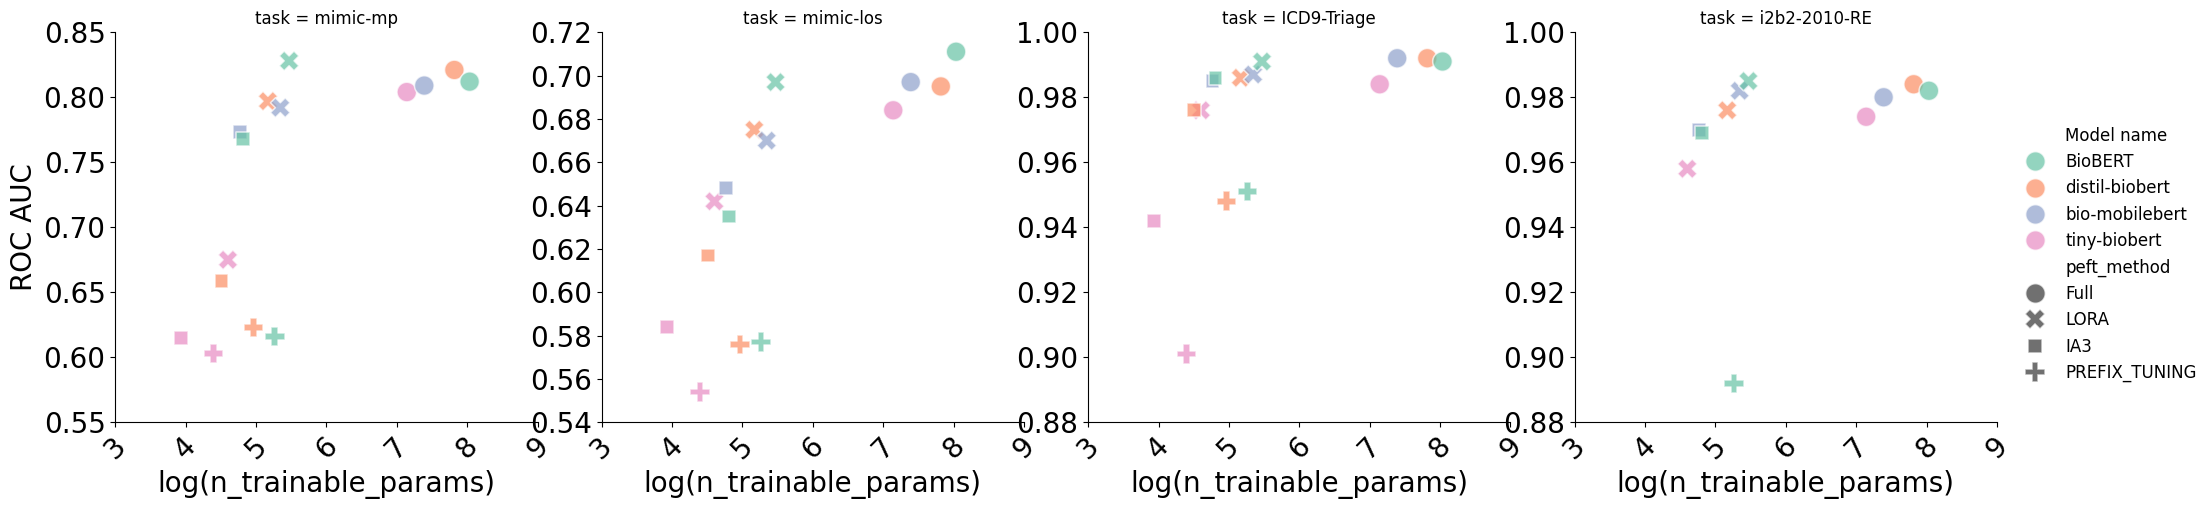

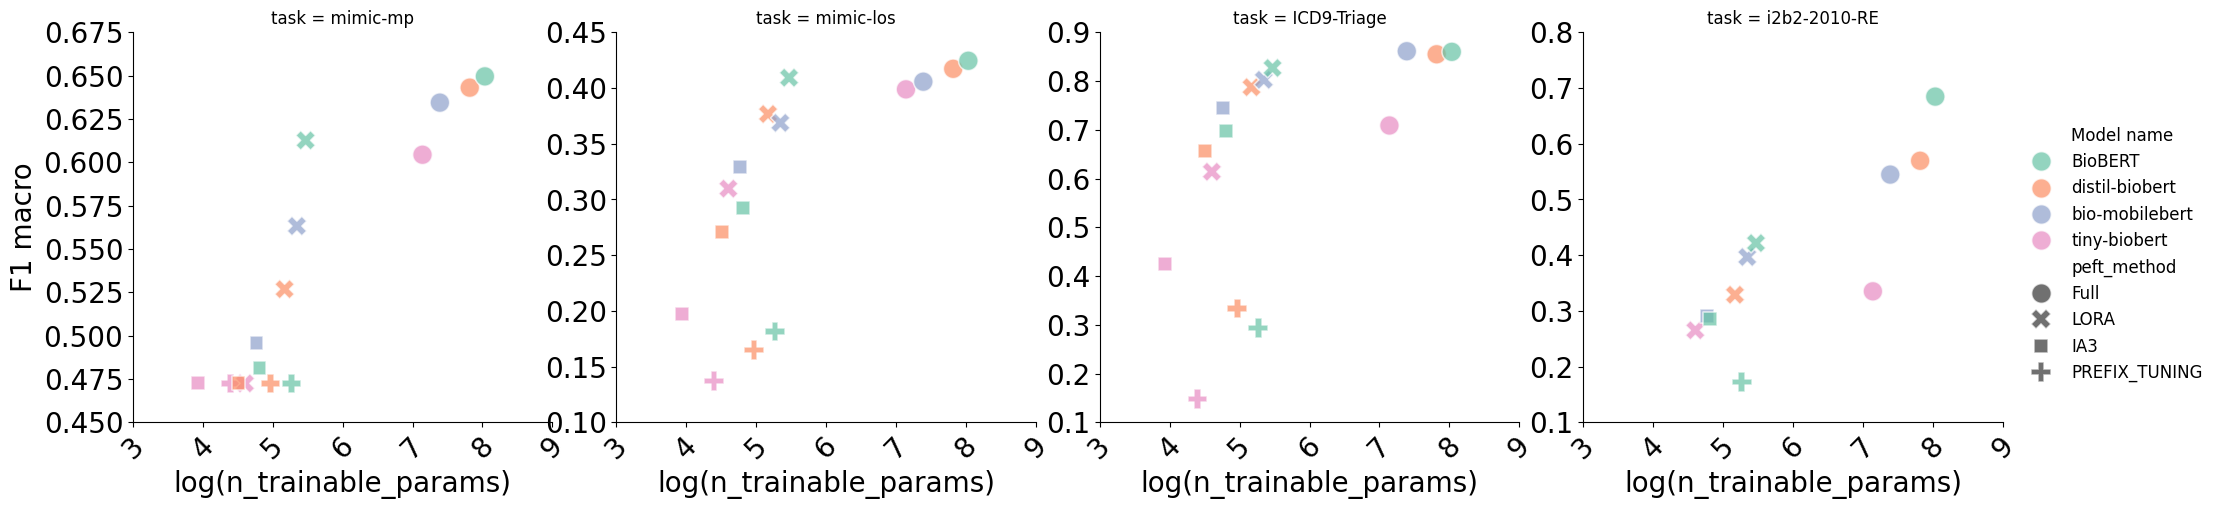

In [20]:
metrics = ['roc_auc_macro', 'f1_macro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
# have a nicer metric name mapping


for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
                     hue='Model name',
                     hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                       palette='Set2', s=200, alpha=0.7,
                     style_order=peft_methods_to_plot[::-1])
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45, fontsize =20)
    fg.set_yticklabels(fontsize =20)
    fg.set_xlabels('log(n_trainable_params)', fontsize =20)
    fg.set_ylabels(metric_name_mapping[metric], fontsize =20)
    # set subplot titles
    # fg.set_titles(col_template="{col_name}", row_template="{row_name}", fontsize =30)


    plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params.png', bbox_inches='tight')
    plt.show()


In [104]:
# plt.rcParams

the style order may be weird

In [44]:
# Plot the lines on two facets
# sns.relplot(
#     data=dots,
#     x="time", y="firing_rate",
#     hue="coherence", size="choice", col="align",
#     kind="line", size_order=["T1", "T2"], palette=palette,
#     height=5, aspect=.75, facet_kws=dict(sharex=False),
# )

In [134]:
plot_df.query("`Model name` == 'Bio-ClinicalBERT' & `task` == 'mimic-los'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,PEFT_params,PEFT_params_perc,Total_params,log(n_trainable_params)
33,33,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,Full,0.443862,0.422290,0.443862,0.438665,0.461359,0.415032,0.705,229376,0.211774,108311810,5.360548
34,34,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PREFIX_TUNING,0.410840,0.368367,0.410840,0.393162,0.470111,0.362654,0.672,368640,0.340351,108311810,5.566602
35,35,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PROMPT_TUNING,0.377591,0.268441,0.377591,0.329927,0.442458,0.289024,0.608,7680,0.007091,108311810,3.885361


### Compare multiple models at full sample size

In [91]:
# set models of interest

models_of_interest = ["roberta-base", "Bio_ClinicalBERT", "mimic-roberta-base", "bio-mobilebert", "distil-biobert"]

<Figure size 1200x1000 with 0 Axes>

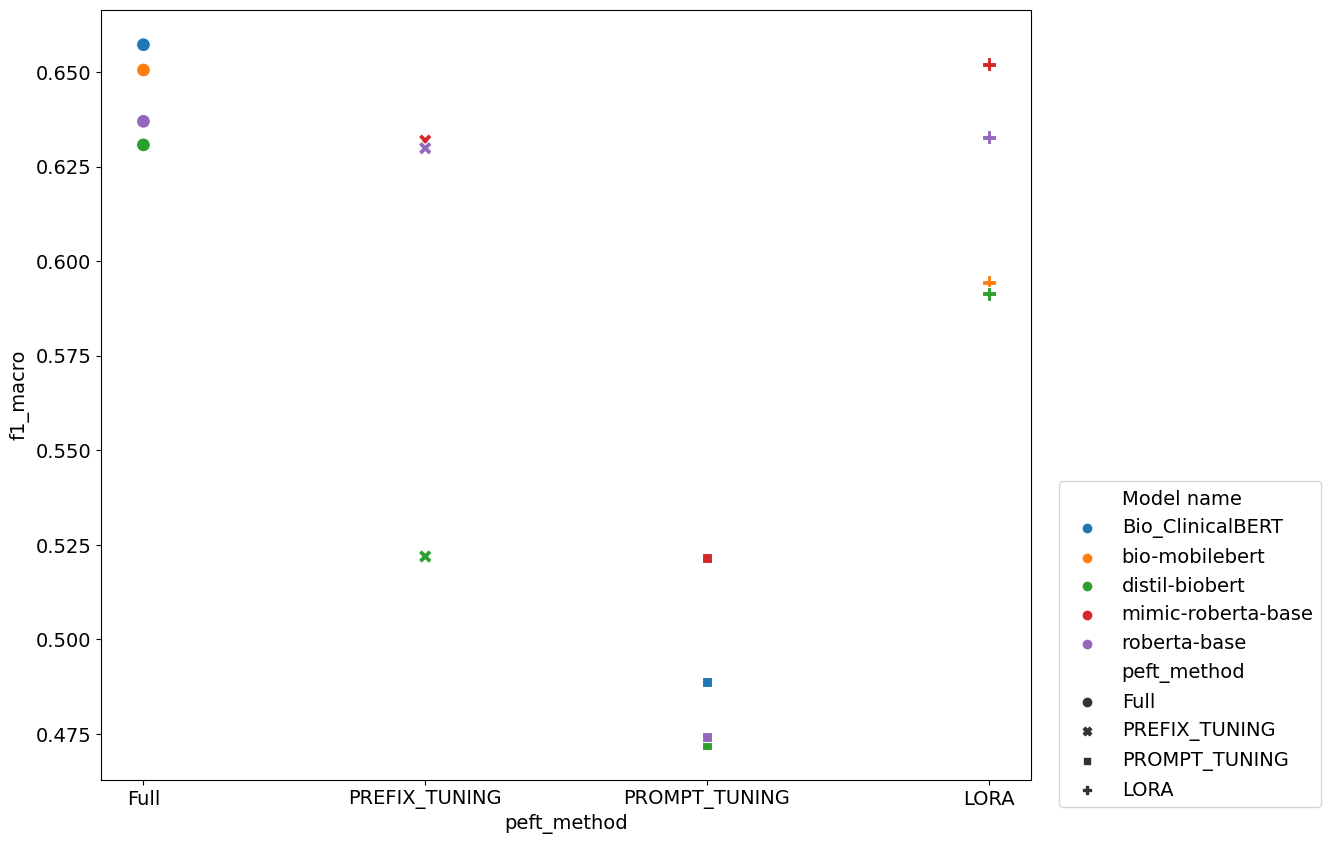

<Figure size 1200x1000 with 0 Axes>

In [18]:
task = "mimic-mp"


# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                        ax =ax, 
                        legend = False
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))

# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


# ax.axhline(y=cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)

In [31]:
logs_df.task_type.unique()

array(['SEQ_CLS', 'TOKEN_CLS'], dtype=object)

### Look at training time etc

In [33]:
cls_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params
0,0,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,Full,0.948940,0.879353,0.948940,0.949106,...,0.885844,0.993043,1.178996e+16,0.182213,1151.783691,41.497002,1.298,108310272.0,99.998580,108311810.0
1,1,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,IA3,0.904303,0.661928,0.904303,0.889988,...,0.656008,0.982280,1.179958e+16,0.508661,1016.591003,47.014999,1.471,64512.0,0.059561,108311810.0
2,2,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,LORA,0.948298,0.876338,0.948298,0.948010,...,0.874291,0.991595,1.183130e+16,0.281233,973.616028,49.090000,1.536,294912.0,0.272281,108311810.0
3,3,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PREFIX_TUNING,0.758831,0.377884,0.758831,0.702254,...,0.370109,0.904001,1.179070e+16,0.945242,911.373108,52.443001,1.640,184320.0,0.170175,108311810.0
4,4,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PROMPT_TUNING,0.724470,0.309875,0.724470,0.646503,...,0.328047,0.892517,1.179070e+16,1.019554,930.424622,51.368999,1.607,7680.0,0.007091,108311810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,328,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,IA3,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.610758,2.286669e+15,0.338250,628.517273,270.112000,8.448,8544.0,0.061579,13874762.0
329,329,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,LORA,0.895273,0.483743,0.895273,0.847377,...,0.505564,0.758608,2.302018e+15,0.310653,592.793823,286.390015,8.958,39936.0,0.287832,13874762.0
330,330,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PREFIX_TUNING,0.894662,0.484691,0.894662,0.846581,...,0.505162,0.737646,2.282492e+15,0.317243,778.098083,218.186005,6.824,24960.0,0.179895,13874762.0
331,331,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PROMPT_TUNING,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.608066,2.282492e+15,0.335948,878.742371,193.197006,6.043,3120.0,0.022487,13874762.0


In [34]:
time_grouped_df = cls_results_df.groupby(["Model name", 
                                          "peft_method",
                                          "task",
                                          "few_shot_n"])[["train/train_runtime","train/total_flos", "f1_macro"]].mean().reset_index()

In [32]:
time_grouped_df.query("`Model name` == 'tiny-biobert' & task == 'mimic-los'")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
311,tiny-biobert,Full,mimic-los,250.0,672.981689,2.044993e+15,0.394912
316,tiny-biobert,IA3,mimic-los,250.0,567.254883,2.049284e+15,0.200045
326,tiny-biobert,LORA,mimic-los,16.0,50.236301,4.340235e+12,0.082366
327,tiny-biobert,LORA,mimic-los,32.0,51.597698,8.680469e+12,0.117975
328,tiny-biobert,LORA,mimic-los,64.0,52.520100,1.736094e+13,0.185895
329,tiny-biobert,LORA,mimic-los,128.0,57.049000,3.472188e+13,0.229567
330,tiny-biobert,LORA,mimic-los,200.0,61.754700,5.425293e+13,0.239175
331,tiny-biobert,LORA,mimic-los,250.0,529.658508,2.063036e+15,0.332569
341,tiny-biobert,PREFIX_TUNING,mimic-los,250.0,696.214905,2.045541e+15,0.303347
346,tiny-biobert,PROMPT_TUNING,mimic-los,250.0,784.993591,2.045541e+15,0.200091


In [37]:
time_grouped_df.query("peft_method == 'LORA' and few_shot_n == 250")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
10,Bio-ClinicalBERT,LORA,ICD9-Triage,250.0,973.616028,1.183130e+16,0.876338
16,Bio-ClinicalBERT,LORA,i2b2-2010-RE,250.0,1168.505249,1.361401e+16,0.406977
17,Bio-ClinicalBERT,LORA,mednli,250.0,217.321594,3.172938e+15,0.266870
21,Bio-ClinicalBERT,LORA,mimic-los,250.0,2841.795898,3.765043e+16,0.400606
23,Bio-ClinicalBERT,LORA,mimic-mp,250.0,3164.370850,4.202153e+16,0.636708
44,BioLinkBERT-base,LORA,i2b2-2010-RE,250.0,1608.011230,1.207389e+16,0.468533
45,BioLinkBERT-base,LORA,mednli,250.0,281.238190,2.614242e+15,0.269277
46,BioLinkBERT-base,LORA,mimic-los,250.0,2780.993896,3.765043e+16,0.411788
47,BioLinkBERT-base,LORA,mimic-mp,250.0,3105.887695,4.202153e+16,0.651606
68,LinkBERT-base,LORA,i2b2-2010-RE,250.0,1858.796143,1.368241e+16,0.369720


In [35]:
# peft_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
peft_methods_to_plot = ['IA3', 'LORA', 'Full']
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['distil-biobert', 'bio-mobilebert', 'tiny-biobert', 'BioBERT'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]

plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [40]:
cls_results_df["Model name"].unique()

array(['Bio-ClinicalBERT', 'BioBERT', 'BioLinkBERT-base', 'LinkBERT-base',
       'Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
       'RoBERTa-mimic-note-two-epoch', 'bio-mobilebert', 'distil-biobert',
       'roberta-base-mimic-note-custom_pretraining_contrastive_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

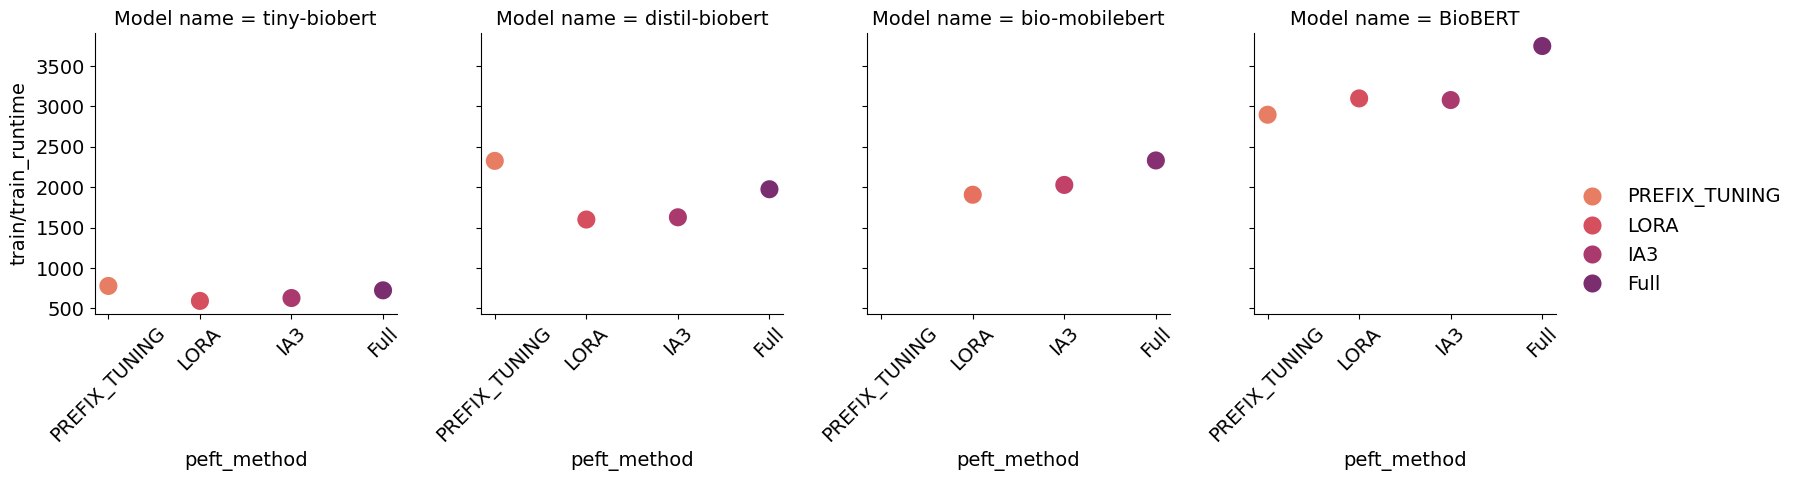

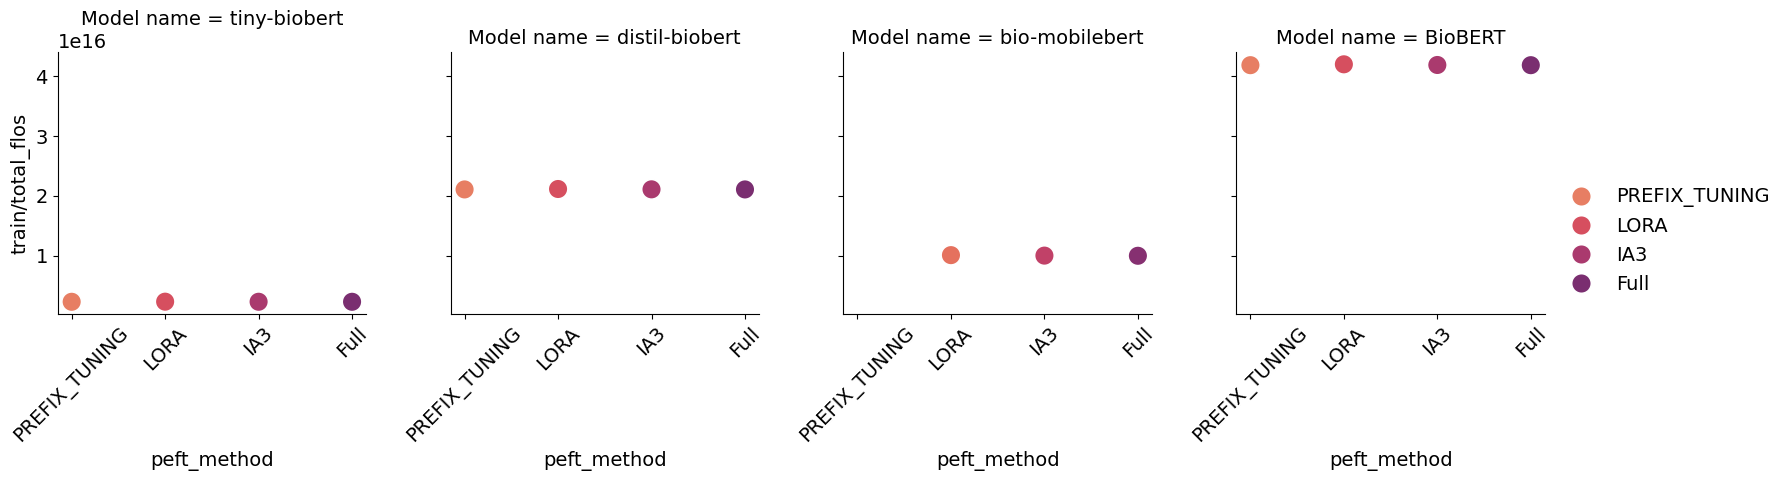

In [71]:
task = "mimic-mp"

metrics = ["train/train_runtime","train/total_flos"]

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df.query("task == @task"), col='Model name', sharey=True, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.scatterplot, x='peft_method', y=metric, hue='peft_method', 
                    # order=peft_methods_to_plot, 
                    palette='flare',
                    s = 200)
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

In [40]:
# how many nas in train_runtime
plot_df["train/total_flos"].isna().sum()

0

In [39]:
plot_df["train/train_runtime"]

351     778.098083
340     696.214905
329      68.249603
323     265.755798
312     262.315308
          ...     
57     3748.081299
55      388.900787
49      280.701111
44     1384.306396
39     1138.175049
Name: train/train_runtime, Length: 75, dtype: float64

In [76]:
plot_df.query("`Model name` == 'bio-mobilebert' & `task` == 'mimic-mp'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,log(train/train_runtime)
259,259,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,LORA,0.897922,0.594404,NaN,0.870632,...,0.805,1.008930e+16,80.762421,1907.081055,89.021004,2.784,221184.0,0.899747,24582914.0,3.280369
258,258,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,IA3,0.894662,0.506085,0.894662,0.851521,...,0.760,1.000969e+16,55.185074,2028.612427,83.688004,2.618,58368.0,0.237433,24582914.0,3.307199
257,257,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,Full,0.901793,0.650529,0.901793,0.880001,...,0.824,9.980649e+15,59.196644,2331.474121,73.668999,2.304,24581888.0,99.995826,24582914.0,3.367631


ValueError: s must be a scalar, or float array-like with the same size as x and y

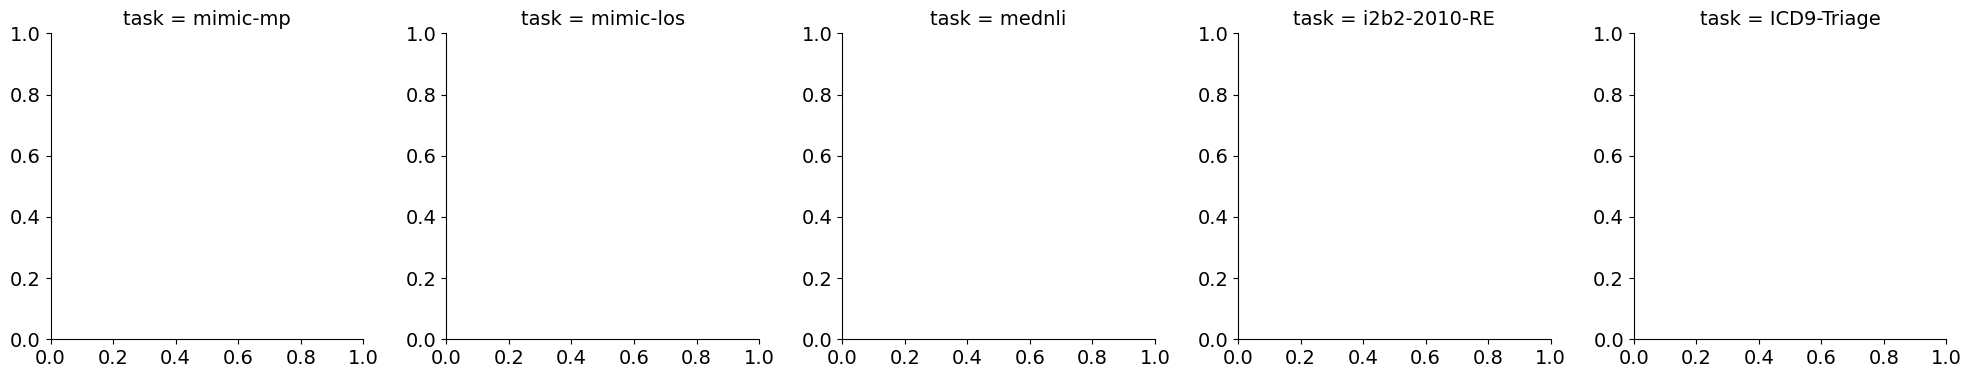

In [51]:
task = "mimic-mp"
peft_methods_to_plot = ["IA3", "LORA","Full"]
metrics = ["f1_macro", "roc_auc_macro"]
time_metric = "train/train_runtime"
plot_df['log(n_trainable_params)'] = np.log2(plot_df['PEFT_params'])
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, sharex=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.scatterplot, x=time_metric, y=metric ,
                    hue='Model name',
                    palette='viridis',
                    style = "peft_method",
                    # size = 'log(n_trainable_params)',
                    # size = 200,
                    s = plot_df["log(n_trainable_params)"],
                    )
    
    # remove x ticks
    fg.set(xticks=[])
    
    # fg.map_dataframe(sns.lineplot,
    #                  x = metric, 
    #                  y = cls_metric,
                      
    #                 palette='flare')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

In [52]:
task

'mimic-mp'

Text(0.5, 1.0, 'Scatterplot with Seaborn')

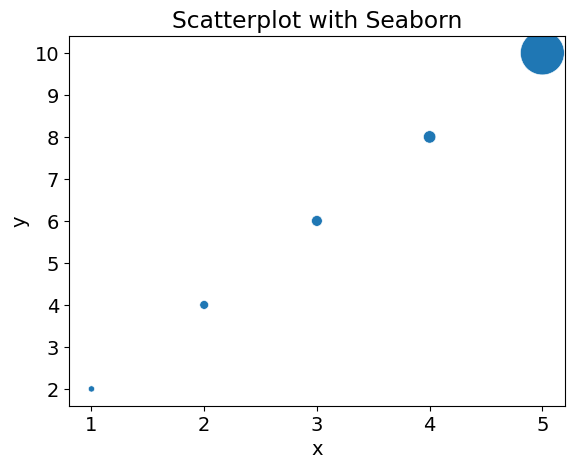

In [88]:

df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 
                   'y': [2, 4, 6, 8, 10],
                   'size': [20.0, 40, 60, 80, 1000]})

ax = sns.scatterplot(data=df, x='x', y='y', s=df['size'])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Scatterplot with Seaborn')

In [64]:
df

,x,y,size
0,1,2,20
1,2,4,40
2,3,6,60
3,4,8,80
4,5,10,100


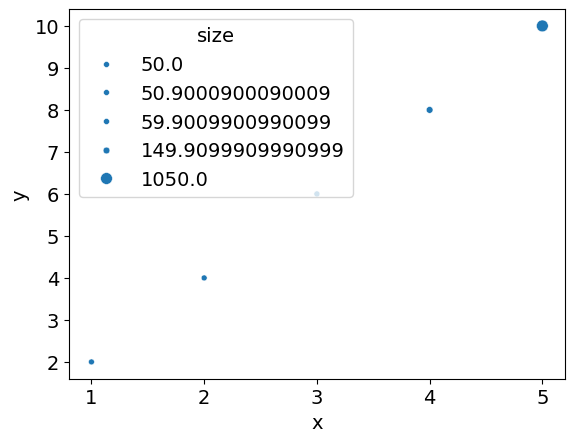

In [104]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'x': [1, 2, 3, 4, 5],  
                   'y': [2, 4, 6, 8, 10],
                   'size': [1000, 10000, 100000, 1000000, 10000000]})

# Normalize sizes to range from 50 to 500
sizes = 50 + (df['size'] - df['size'].min()) / (df['size'].max() - df['size'].min()) * 1000

ax = sns.scatterplot(data=df, x='x', y='y', size=sizes)

# ax.set_yscale('log')

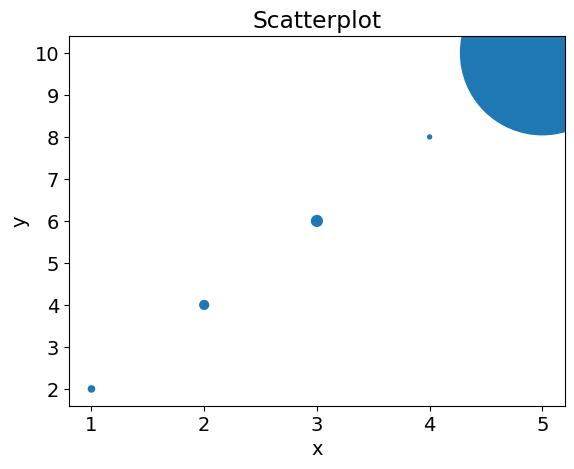

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 
                   'y': [2, 4, 6, 8, 10],
                   'size': [20, 40, 60, 8, 13874.0]})

plt.scatter(df['x'], df['y'], s=df['size'])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot')

plt.show()

In [97]:
# mean std scaling of peft params
# plot_df['norm_PEFT_params'] = ((plot_df['PEFT_params'] - plot_df['PEFT_params'].mean()) / plot_df['PEFT_params'].std())*10
plot_df['norm_PEFT_params'] = (plot_df['PEFT_params'])/1000

(array([41.,  5.,  5.,  0.,  0.,  0.,  5.,  0.,  0.,  5.]),
 array([8.54400000e+00, 1.08387168e+04, 2.16688896e+04, 3.24990624e+04,
        4.33292352e+04, 5.41594080e+04, 6.49895808e+04, 7.58197536e+04,
        8.66499264e+04, 9.74800992e+04, 1.08310272e+05]),
 <BarContainer object of 10 artists>)

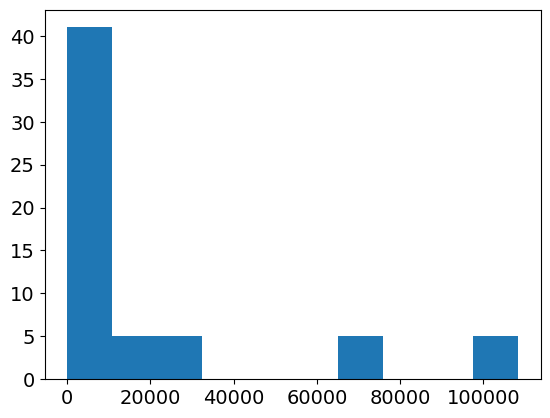

In [98]:
plt.hist(plot_df['norm_PEFT_params'])

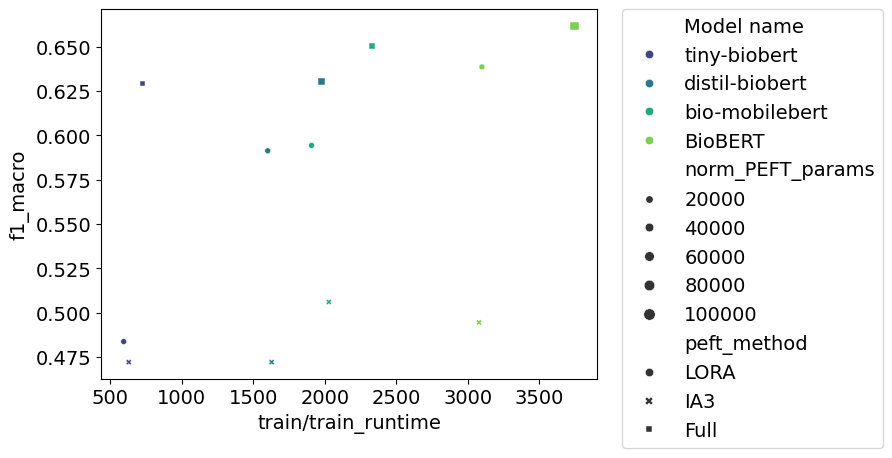

In [99]:
# single task plot
pdf = plot_df.query("task == @task").reset_index(drop=True)
sns.scatterplot(x="train/train_runtime", y=metric ,
                    hue='Model name',
                    palette='viridis',
                    style = "peft_method",
                    size = pdf["norm_PEFT_params"],
                    data = pdf)

# move legend outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    

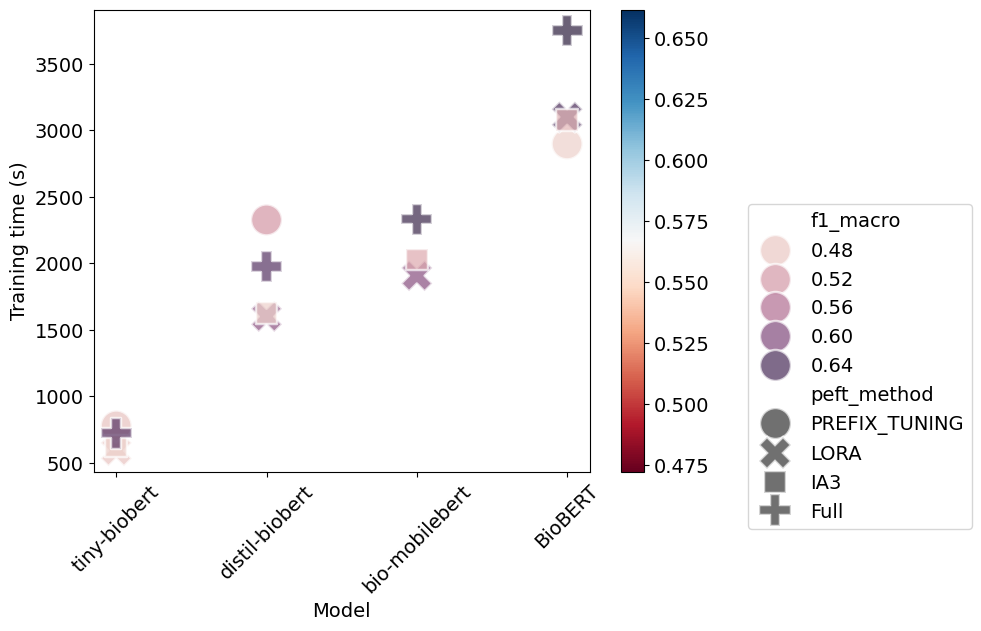

In [47]:
# make plot
plt.figure(figsize=(8, 6))
cls_metric = "f1_macro"
peft_type = "LORA"
time_plot_df = plot_df.query("task == @task and peft_method == @peft_type")
time_plot_df = plot_df.query("task == @task")
ax = sns.scatterplot(data = time_plot_df,
                     x = "Model name",
                     y = "train/train_runtime",
                     hue = cls_metric,
                     style="peft_method",
                     s = 500,
                     alpha = 0.7,
                     
                     )
norm = plt.Normalize(time_plot_df[cls_metric].min(), time_plot_df[cls_metric].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)
# plt.suptitle(f"Alignment vs Uniformity for label {label}")
plt.xlabel("Model")
# rotate x tick labels by 45
plt.xticks(rotation=45)
plt.ylabel("Training time (s)")

    # for line in range(0,uniform_align_dfs.shape[0]):
    #     # print(f"line {line}")
    #     plt.text(uniform_align_dfs.iloc[line].uniform_loss+0.002, uniform_align_dfs.iloc[line].align_loss+0.02, uniform_align_dfs.iloc[line].model_name, horizontalalignment='center', size='medium', color='black', weight='semibold')
# texts = []
# for line in range(0,time_plot_df.shape[0]):
#     texts.append(plt.text(time_plot_df.iloc[line]["train/train_runtime"]+0.002,
#                           time_plot_df.iloc[line]["train/train_runtime"]+0.02,
#                           time_plot_df.iloc[line]["Model name"],
#                           horizontalalignment='left',
#                           size='medium',
#                           color='black',
#                           weight='semibold'))


# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))
# adjust_text(texts)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.3, 0.6))
plt.savefig(f'{save_path}/{cls_metric}_peft_methods_train_time.png', bbox_inches='tight')
plt.show()

### Storage analysis

In [26]:
model_type_size_mappings

{'distil': {'LORA': {'full_model_size_GB': 0.49018238950520754,
   'full_model_size_MB': 501.9467668533325,
   'model_size_GB': 0.24506665021181107,
   'model_size_MB': 250.94824981689453,
   'n_trainable_params': 147456,
   'n_trainable_params_perc': 0.2241497999728751,
   'peft_full_model_size_GB': 0.24627410527318716,
   'peft_full_model_size_MB': 252.18468379974365,
   'peft_model_size_GB': 0.00054931640625,
   'peft_model_size_MB': 0.5625,
   'total_trainable_params': 65784578},
  'PREFIX_TUNING': {'full_model_size_GB': 0.49018238950520754,
   'full_model_size_MB': 501.9467668533325,
   'model_size_GB': 0.24506665021181107,
   'model_size_MB': 250.94824981689453,
   'n_trainable_params': 92160,
   'n_trainable_params_perc': 0.14009362498304695,
   'peft_full_model_size_GB': 0.24638669844716787,
   'peft_full_model_size_MB': 252.2999792098999,
   'peft_model_size_GB': 0.00034332275390625,
   'peft_model_size_MB': 0.3515625,
   'total_trainable_params': 65784578},
  'PROMPT_TUNING':

In [12]:
# do above for all keys
# then concat all together
# then merge with cls_results_df

# create list of dataframes
dfs = []
for key in model_type_size_mappings.keys():
    df = pd.DataFrame(model_type_size_mappings[key]).T.reset_index().rename(columns={"index":"peft_type"})
    df["model_type"] = key
    # append to list
    dfs.append(df)
    
# concat all together
model_type_size_df = pd.concat(dfs)

In [51]:
model_type_size_df

,peft_type,full_model_size_GB,full_model_size_MB,model_size_GB,model_size_MB,n_trainable_params,n_trainable_params_perc,peft_full_model_size_GB,peft_full_model_size_MB,peft_model_size_GB,peft_model_size_MB,total_trainable_params,model_type
0,LORA,0.490182,501.946767,0.245067,250.948250,147456.0,0.224150,0.246274,252.184684,0.000549,0.562500,6.578458e+07,distil
1,PREFIX_TUNING,0.490182,501.946767,0.245067,250.948250,92160.0,0.140094,0.246387,252.299979,0.000343,0.351562,6.578458e+07,distil
2,PROMPT_TUNING,0.490182,501.946767,0.245067,250.948250,10756.0,0.016350,0.245194,251.078483,0.000040,0.041031,6.578458e+07,distil
3,P_TUNING,0.490182,501.946767,0.245067,250.948250,221696.0,0.337003,0.247358,253.294841,0.000826,0.845703,6.578458e+07,distil
0,LORA,49.353743,50538.232680,24.614304,25205.046875,4194304.0,0.063479,24.770985,25365.488444,0.015625,16.000000,6.607352e+09,llama-7b
1,PREFIX_TUNING,49.353743,50538.232680,24.614304,25205.046875,2621440.0,0.039675,24.774753,25369.347331,0.009766,10.000000,6.607352e+09,llama-7b
2,PROMPT_TUNING,49.353743,50538.232680,24.614304,25205.046875,57344.0,0.000868,24.739845,25333.601352,0.000214,0.218750,6.607352e+09,llama-7b
3,P_TUNING,49.353743,50538.232680,24.614304,25205.046875,1110272.0,0.016804,24.763512,25357.835853,0.004136,4.235352,6.607352e+09,llama-7b
0,LORA,0.183584,187.989936,0.091578,93.776375,221184.0,0.899747,0.093835,96.086712,0.000824,0.843750,2.458291e+07,mobile
1,PREFIX_TUNING,0.183584,187.989936,0.091578,93.776375,245760.0,0.999719,0.094868,97.145123,0.000916,0.937500,2.458291e+07,mobile


/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

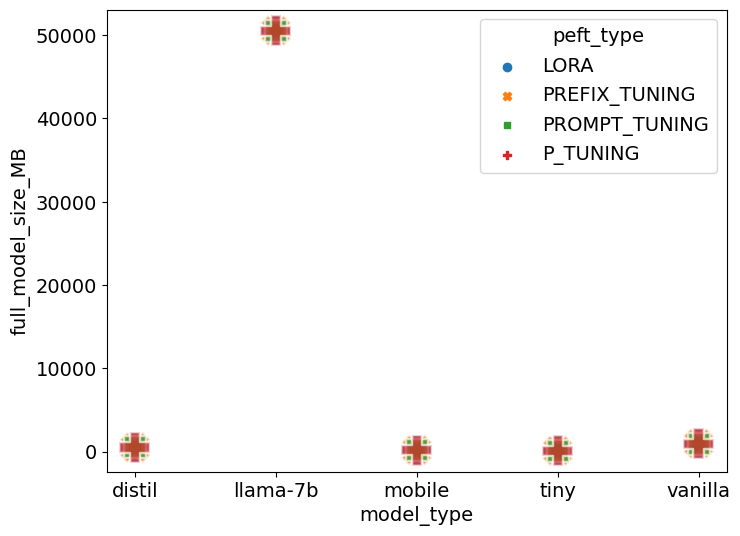

In [53]:
# plot the model type size df
# look at model type vs full model size
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data = model_type_size_df,
                     x = "model_type",
                     y = "full_model_size_MB",
                     hue = "peft_type",
                     style="peft_type",
                     s = 500,
                     alpha = 0.7,
                     
                     )


## Sensitivity analysis


## domain pre-training

In [48]:
cls_results_df.few_shot_n.unique()

array([250.])

In [21]:
dm_peft_methods_to_plot = ["LORA","Full"]

In [22]:
dm_plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
dm_plot_df =  dm_plot_df.loc[dm_plot_df['task'] != 'mednli']
# dm_plot_df = dm_plot_df.loc[dm_plot_df['Model name'].isin(
#     ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
dm_plot_df = dm_plot_df.loc[dm_plot_df['peft_method'].isin(dm_peft_methods_to_plot)]
dm_plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
dm_plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
dm_plot_df['roc_auc_macro'] = dm_plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [69]:
dm_plot_df.query("`Model name` == 'RoBERTa-base'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB,log(n_trainable_params),Domain pretraining,Model type
19,19,RoBERTa-base,roberta-base,mimic-mp,250.0,LORA,0.900224,0.605469,0.532737,0.605469,...,294912.0,0.236597,124647170.0,0.464347,475.491219,0.464347,475.491219,5.469692,General,RoBERTa


In [17]:
dm_plot_df["Model name"].unique()

array(['tiny-clinicalbert', 'tiny-biobert', 'mobilebert-uncased',
       'distil-biobert', 'clinical-mobilebert', 'clinical-distilbert',
       'bio-mobilebert', 'TinyBERT_General_4L_312D', 'RoBERTa-base',
       'DistilBERT-base', 'BioBERT', 'Bio-ClinicalBERT', 'BERT-base'],
      dtype=object)

In [23]:
# plotting order 
dm_peft_model_order = ["tiny-biobert", "tiny-clinicalbert","bert-tiny", 
                       "bio-mobilebert", "clinical-mobilebert" ,"mobilebert-uncased",
                       "distil-biobert", "clinical-distilbert", "DistilBERT-base",
                       "BERT-base", "BioBERT", "RoBERTa-base"]

# set mapping of domain pre-training to model name
dm_model_mapping = {"TinyBERT_General_4L_312D":"General",
                    "mobilebert-uncased":"General",
                    "DistilBERT-base":"General",
                    "BioBERT":"Bio",
                    "tiny-biobert":"Bio",
                    "bio-mobilebert":"Bio",
                    "distil-biobert":"Bio",
                    "BERT-base":"General",
                    # "RoBERTa-base":"General",
                    "Bio-ClinicalBERT":"Clinical",
                    "tiny-clinicalbert":"Clinical",
                    "clinical-mobilebert":"Clinical",
                    "clinical-distilbert":"Clinical"}

# set a model type mapping too for plotting
dm_model_type_mapping = {"TinyBERT_General_4L_312D":"tiny",
                    "mobilebert-uncased":"mobile",
                    "DistilBERT-base":"distil",
                    "BioBERT":"BERT",
                    "tiny-biobert":"tiny",
                    "bio-mobilebert":"mobile",
                    "distil-biobert":"distil",
                    "BERT-base":"BERT",
                    # "RoBERTa-base":"RoBERTa",
                    "tiny-clinicalbert":"tiny",
                    "clinical-mobilebert":"mobile",
                    "clinical-distilbert":"distil",
                    "Bio-ClinicalBERT":"BERT"}

# add as new column
dm_plot_df["Domain pretraining"] = dm_plot_df["Model name"].map(dm_model_mapping)
# add type mapping too
dm_plot_df["Model type"] = dm_plot_df["Model name"].map(dm_model_type_mapping)

In [54]:
dm_plot_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'PEFT_params', 'PEFT_params_perc', 'Total_params', 'full_model_size_GB',
       'full_model_size_MB', 'peft_full_model_size_GB',
       'peft_full_model_size_MB', 'Domain pretraining', 'Model type'],
      dtype='object', name='tag')

In [86]:
dm_plot_df.query("task == 'i2b2-2010-RE'")[["Model name", "Domain pretraining", "peft_method", "eval/f1_macro", "eval/f1_micro", "eval/roc_auc_macro","f1_weighted"]]

tag,Model name,Domain pretraining,peft_method,eval/f1_macro,eval/f1_micro,eval/roc_auc_macro,f1_weighted
117,tiny-clinicalbert,Clinical,LORA,0.319277,0.901070,0.967912,0.894316
116,tiny-clinicalbert,Clinical,Full,0.339610,0.912326,0.971817,0.906660
105,tiny-biobert,Bio,LORA,0.268724,0.887023,0.953217,0.869152
104,tiny-biobert,Bio,Full,0.333454,0.907860,0.972151,0.903352
95,mobilebert-uncased,General,LORA,0.405351,0.911442,0.979771,0.905170
94,mobilebert-uncased,General,Full,0.525380,0.927953,0.984873,0.925160
83,distil-biobert,Bio,LORA,0.328647,0.908465,0.975334,0.900034
82,distil-biobert,Bio,Full,0.561167,0.928326,0.984173,0.927556
73,clinical-mobilebert,Clinical,LORA,0.379910,0.918326,0.979691,0.906363
72,clinical-mobilebert,Clinical,Full,0.610549,0.935349,0.985418,0.932825


In [87]:
dm_plot_df.query("task == 'mimic-los'")[["Model name", "Domain pretraining", "peft_method", "eval/f1_macro", "eval/f1_micro", "eval/roc_auc_macro","f1_weighted"]]

tag,Model name,Domain pretraining,peft_method,eval/f1_macro,eval/f1_micro,eval/roc_auc_macro,f1_weighted
119,tiny-clinicalbert,Clinical,LORA,0.330938,0.401275,0.653870,0.400425
118,tiny-clinicalbert,Clinical,Full,0.384684,0.424732,0.683137,0.433733
108,tiny-biobert,Bio,LORA,0.300728,0.387611,0.635998,0.365567
106,tiny-biobert,Bio,Full,0.380408,0.421089,0.673502,0.418606
97,mobilebert-uncased,General,LORA,0.348924,0.406513,0.651268,0.395369
96,mobilebert-uncased,General,Full,0.409864,0.439080,0.695632,0.435117
86,distil-biobert,Bio,LORA,0.352438,0.406286,0.660010,0.407209
84,distil-biobert,Bio,Full,0.410929,0.429970,0.690352,0.434849
75,clinical-mobilebert,Clinical,LORA,0.370204,0.414940,0.676351,0.406487
74,clinical-mobilebert,Clinical,Full,0.418866,0.450011,0.710851,0.449609


### the task here may be quite important

mimic-mp, mimic-los, and ICD9 may be unfair as the clinical models have been trained on presumably all mimic notes

############## Task is : i2b2-2010-RE ##############


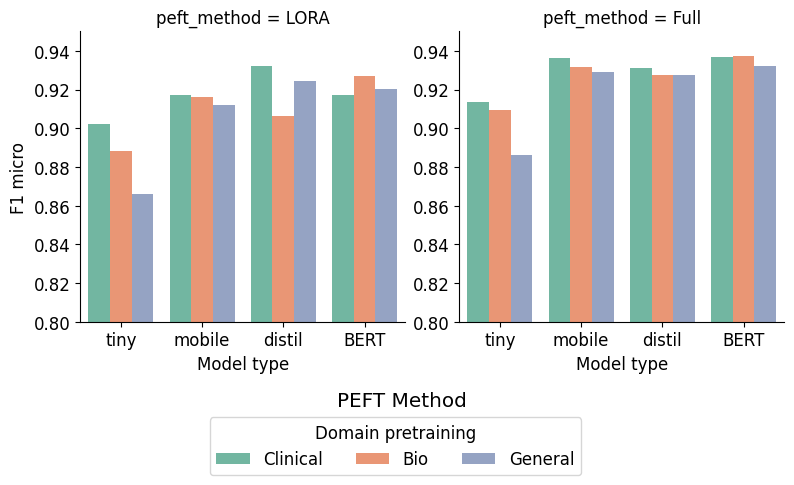

In [27]:
# metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted']
metrics = ['f1_micro']

dm_plot_df['log(n_trainable_params)'] = np.log10(dm_plot_df['PEFT_params'])


# tasks = ["mimic-los", "mimic-mp", "ICD9-Triage", "i2b2-2010-RE"]
tasks = [ "i2b2-2010-RE"]

# loop over task
for task in tasks:
        print(f"############## Task is : {task} ##############")
        for metric in metrics:
                # change font size
                

                # fig, ax = plt.subplots(figsize=(7,7))
                g = sns.FacetGrid(data = dm_plot_df.query("task == @task"),
                                col='peft_method',
                                sharey=False, 
                                legend_out=True, 
                                aspect = 1, 
                                height = 4)
                g.map_dataframe(sns.barplot,
                                x = "Model type",
                                y = metric,
                                hue = "Domain pretraining",
                                palette='Set2',
                                )
                
                # add y limit to facegrid plot
                g.set(ylim=(0.8, 0.95))
                
                plt.legend(
                        title = "Domain pretraining",
                        loc='upper right', 
                        bbox_to_anchor=(0.4, -0.3),  
                        fancybox=True, shadow=False, 
                        ncol=5
                        )

                # replace y axis with metric name
                g.set_ylabels(metric_name_mapping[metric])

                plt.suptitle("PEFT Method", x=0.5, y=0, ha='center')
                # plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
                # save
                plt.savefig(f'{save_path}/{task}_{metric}_peft_methods_dm.png', bbox_inches='tight')
                plt.show()

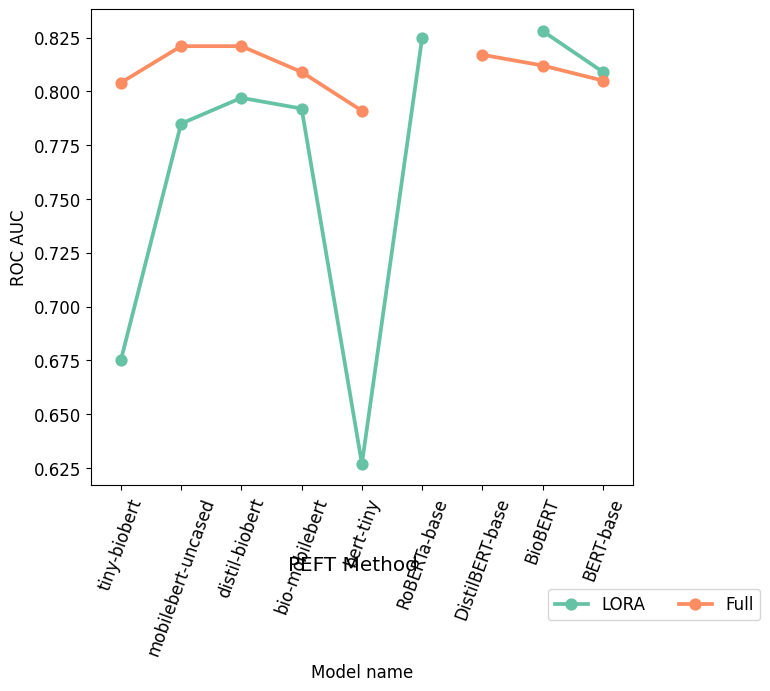

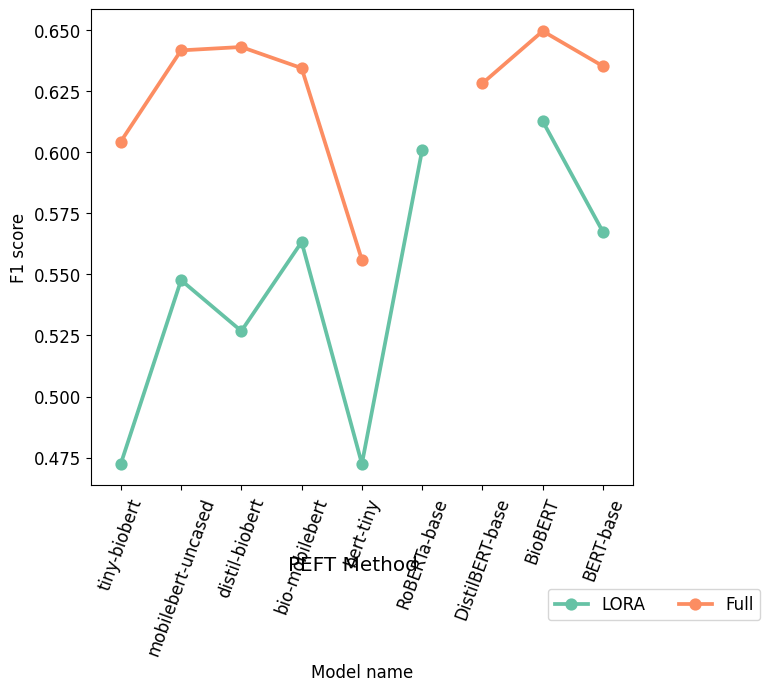

In [54]:
metrics = ['roc_auc_macro', 'f1_macro']
dm_plot_df['log(n_trainable_params)'] = np.log10(dm_plot_df['PEFT_params'])
# have a nicer metric name mapping
metric_name_mapping = {'roc_auc_macro': 'ROC AUC', 'f1_macro': 'F1 score'}

for metric in metrics:
        # change font size
        task = "mimic-mp"

        fig, ax = plt.subplots(figsize=(7,7))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
        sns.pointplot(data = dm_plot_df.query("task == @task"),
                x = "Model name",
                y = metric,
                hue = "peft_method",

                ax = ax,
                legend = True,
                palette = "Set2"
                )

        # do pointplot instead
        # sns.pointplot(data = fs_cls_results_df.query("peft_method == 'LORA'"),
        #              x = "few_shot_n",
        #              y = metric,
        #              hue = "Model name",
        #              linestyles= "--",
        #              ax = ax,
        #              legend = True
        #              )

        # change y label based on metric mapping
        ax.set_ylabel(metric_name_mapping[metric])
        plt.legend(loc='upper right', 
                bbox_to_anchor=(1.25, -0.2),  
                fancybox=True, shadow=False, 
                ncol=5)
        # rotate x tick labels by 45
        plt.xticks(rotation=70
                   )




        fig.suptitle("PEFT Method", x=0.5, y=0.1, ha='center')
        # plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
        fig.subplots_adjust(bottom=0.2)
        fig.subplots_adjust(wspace=0.25)

        # save
        # plt.savefig(f'{save_path}/few_shot_n_sensitivity.png', bbox_inches='tight')

### Fewshot sampling vs performance

In [26]:
# the dir needs the trailing slash 
# fs_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/fewshot_budget_linearLR/logs/"
fs_logs_dir = "/mnt/sdh/effecient_ml/fewshot_budget/logs/"

In [27]:
# load in the few shot sensitivity logs
fs_logs_df = read_tb_files(fs_logs_dir)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/25617 [00:00<?, ?it/s]

In [28]:
# cls_results_df = produce_results_table(logs_df, 
#                                 metric = ["f1",
#                                         "accuracy",
#                                         "precision",
#                                         "recall",
#                                         "auc", 
#                                         "train/total_flos", "train/train_loss",
#                                         "train/train_runtime", "train/train_samples_per_second",
#                                         "train/train_steps_per_second"],
#                                 mode = "all",
#                                 groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
#                                 task_type = "SEQ_CLS",
#                                 value_aggregate_method = "max",
#                                 )

# do same for fs_logs_df

fs_cls_results_df = produce_results_table(fs_logs_df,
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

In [22]:
fs_cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,16,Full,0.514254,0.542969,0.542906,0.542969,...,0.514254,0.604579,0.512562,0.533600,0.532807,4.735999e+13,0.616700,40.445599,7.912,0.247
1,1,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,16,LORA,0.553044,0.546875,0.545877,0.546875,...,0.553044,0.639203,0.508196,0.521639,0.520717,7.947832e+13,0.680826,47.839199,6.689,0.209
2,2,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,32,Full,0.507941,0.535156,0.534581,0.535156,...,0.507941,0.598894,0.511245,0.530076,0.539727,1.105066e+14,0.674736,50.742500,12.613,0.394
3,3,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,32,LORA,0.384952,0.527344,0.511512,0.527344,...,0.384952,0.471395,0.508643,0.520890,0.525758,1.589566e+14,0.710534,52.774601,12.127,0.379
4,4,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,64,Full,0.599369,0.574219,0.572752,0.574219,...,0.599369,0.677201,0.526088,0.567325,0.593590,3.157333e+14,0.535528,84.508202,15.146,0.473


In [23]:
fs_cls_results_df.few_shot_n.unique()

array([  16,   32,   64,  128,  256,  512, 1024, 2048, 4096])

In [34]:
fs_cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype='object', name='tag')

In [35]:
fs_cls_results_df.query("few_shot_n == 4096")[["Model name", "task", "few_shot_n", "peft_method", "eval/roc_auc_macro", "train/train_runtime"]]

tag,Model name,task,few_shot_n,peft_method,eval/roc_auc_macro,train/train_runtime
16,BioBERT,mimic-mp,4096,Full,0.798677,2025.520508
17,BioBERT,mimic-mp,4096,LORA,0.804639,1547.642700
18,Llama-2-7b,mimic-mp,4096,LORA,0.826167,28254.244141
35,RoBERTa-base,mimic-mp,4096,Full,0.797783,1599.247559
36,RoBERTa-base,mimic-mp,4096,LORA,0.802199,1377.530518
53,bio-mobilebert,mimic-mp,4096,Full,0.803967,989.753906
54,bio-mobilebert,mimic-mp,4096,LORA,0.791002,1051.067993
71,distil-biobert,mimic-mp,4096,Full,0.793782,976.901672
72,distil-biobert,mimic-mp,4096,LORA,0.798827,908.158691
89,tiny-biobert,mimic-mp,4096,Full,0.785742,419.180511


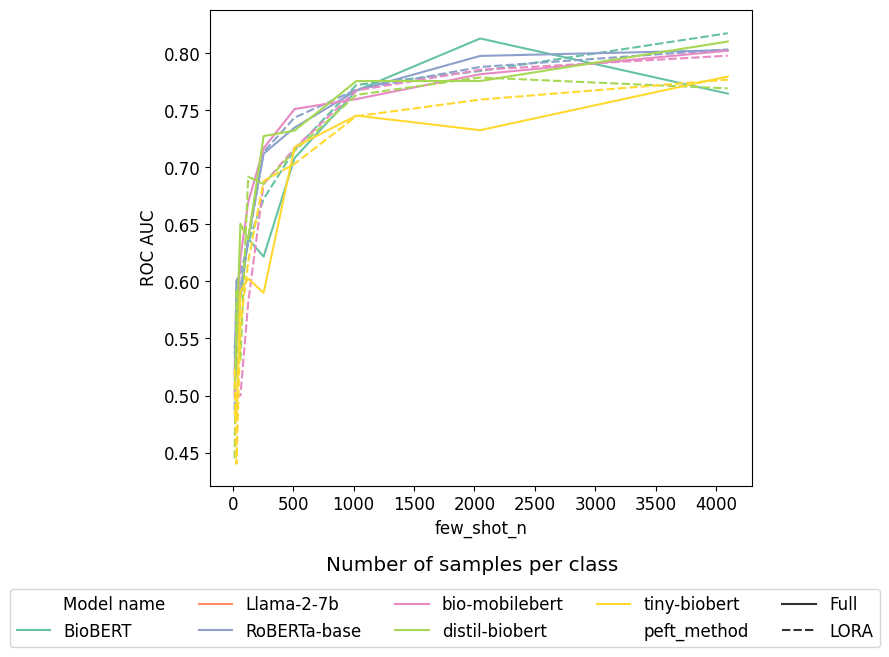

In [29]:
task = "mimic-mp"

fig, ax = plt.subplots(figsize=(7,7))
metric = "roc_auc_macro" # | roc_auc_macro
# lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.lineplot(data = fs_cls_results_df,
             x = "few_shot_n",
             y = metric,
             hue = "Model name",
             style = "peft_method",
             ax = ax,
             legend = True,
             palette = "Set2"
             )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("peft_method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
plt.legend(loc='upper right', 
           bbox_to_anchor=(1.25, -0.2),  
           fancybox=True, shadow=False, 
           ncol=5)


# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above
# ax.axhline(y=cls_results_df.query("`Model name` == 'BioBERT' & task == @task & few_shot_n == 250")["roc_auc_macro"].values[0], color='black', linestyle='--', alpha = 0.5)

fig.suptitle("Number of samples per class", x=0.5, y=0.1, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)

# save
# plt.savefig(f'{save_path}/few_shot_n_sensitivity.png', bbox_inches='tight')

<Figure size 700x700 with 0 Axes>

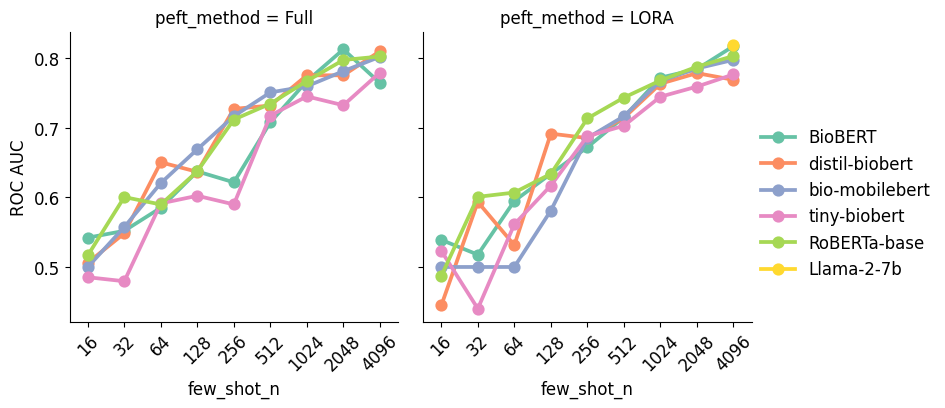

<Figure size 700x700 with 0 Axes>

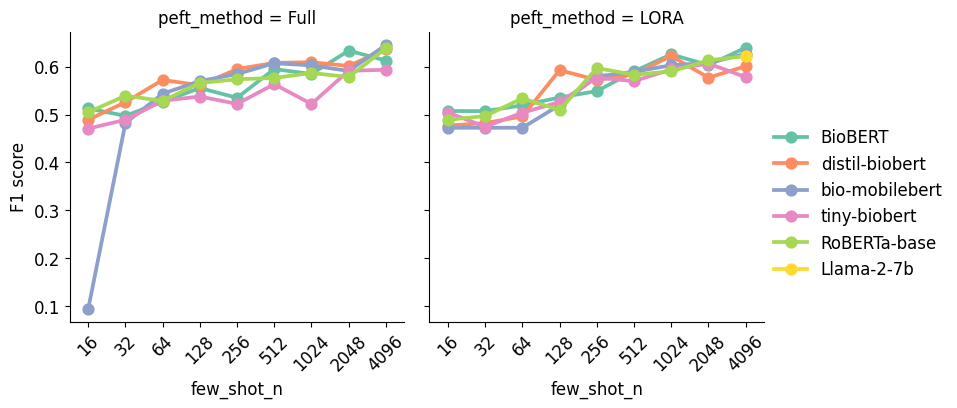

In [30]:
# same as above but with facet

metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:

    plt.figure(figsize=(7, 7))
    fg = sns.FacetGrid(data=fs_cls_results_df,
                        col='peft_method', 
                        sharey=True,
                          sharex=True,
                            legend_out=True,
                              aspect = 1, 
                              height = 4,
                              )
    fg.map_dataframe(sns.pointplot,
                      x='few_shot_n',
                        y=metric,
                          hue='Model name', 
                          hue_order = ["BioBERT", "distil-biobert", "bio-mobilebert", "tiny-biobert", "RoBERTa-base","Llama-2-7b"],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # set y label based on metric mapping
    fg.set_ylabels(metric_name_mapping[metric])
    
    # add grid lines
    # fg.grid()
    # save
    # plt.savefig(f'{save_path}/{metric}_few_shot_n_sensitivity_facet.png', bbox_inches='tight')
    plt.show()

### Lora Rank 

In [65]:
lr_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/lora_rank_analysis/logs/" # need last backslash
lora_logs_df = read_tb_files(lr_logs_dir)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/40434 [00:00<?, ?it/s]

In [67]:
lora_logs_df.head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,test_file,text_col,text_column,train_batch_size,training_data_dir,training_file,validation_file,warmup_steps,save_adapter,Model name
0,299,eval/accuracy,0.924213,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
1,598,eval/accuracy,0.933847,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
2,897,eval/accuracy,0.942197,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
3,1196,eval/accuracy,0.938022,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
4,1495,eval/accuracy,0.942197,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert


In [68]:
lora_logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'custom_model_name', 'data_dir', 'dropout',
       'eight_bit_training', 'eval_batch_size', 'eval_data_dir',
       'eval_every_steps', 'eval_few_shot_n', 'evaluation_strategy',
       'fast_dev_run', 'few_shot_n', 'label_col', 'label_name',
       'learning_rate', 'loader_workers', 'log_every_steps', 'log_save_dir',
       'lora_alpha', 'lora_dropout', 'lora_rank', 'max_epochs', 'max_length',
       'metric_mode', 'model_name_or_path', 'monitor', 'n_trainable_params',
       'no_cuda', 'num_virtual_tokens', 'optimizer', 'patience', 'peft_method',
       'pretrained_models_dir', 'remove_columns', 'save_every_steps',
       'saving_strategy', 'sensitivity', 'task', 'task_to_keys', 'task_type',
       'test_file', 'text_col', 'text_column', 'train_batch_size',
       'training_data_dir', 'training_file', 'validation_file', 'warmup_steps',
       'save_adapter', 'Model name'],
      d

In [69]:
lr_cls_results_df = produce_results_table(lora_logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc", 
                                                   "train/total_flos", "train/train_loss",
                                                "train/train_runtime", "train/train_samples_per_second",
                                                "train/train_steps_per_second"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method", "lora_rank"],
                                        task_type = "SEQ_CLS",
                                        value_aggregate_method = "max",
                                        )

In [71]:
lr_cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,lora_rank,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,LORA,128,0.897107,0.641178,0.897107,0.880251,0.739413,0.611306,0.805939,4.418444e+16,0.284852,3201.988525,53.020000,1.658
1,1,RoBERTa-base,roberta-base,mimic-mp,250,LORA,8,0.898941,0.634734,0.898941,0.877630,0.837479,0.647711,0.813773,4.231030e+16,0.276593,3103.336914,54.706001,1.711
2,2,RoBERTa-base,roberta-base,mimic-mp,250,LORA,16,0.894458,0.472145,0.894458,0.844627,0.447229,0.500000,0.532313,4.245449e+16,0.338095,3097.967773,54.799999,1.714
3,3,RoBERTa-base,roberta-base,mimic-mp,250,LORA,32,0.899144,0.632771,0.899144,0.878094,0.758052,0.618167,0.815220,4.274288e+16,0.275554,3103.418213,54.703999,1.711
4,4,RoBERTa-base,roberta-base,mimic-mp,250,LORA,64,0.897107,0.624484,0.897107,0.875041,0.733170,0.639778,0.813521,4.331965e+16,0.276114,3128.766602,54.261002,1.697


In [72]:
peft_methods_to_plot

['PREFIX_TUNING', 'IA3', 'LORA', 'Full']

In [74]:
plot_df = lr_cls_results_df

plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [80]:
plot_df["Model name"].unique()

array(['tiny-biobert', 'distil-biobert', 'bio-mobilebert', 'BioBERT'],
      dtype=object)

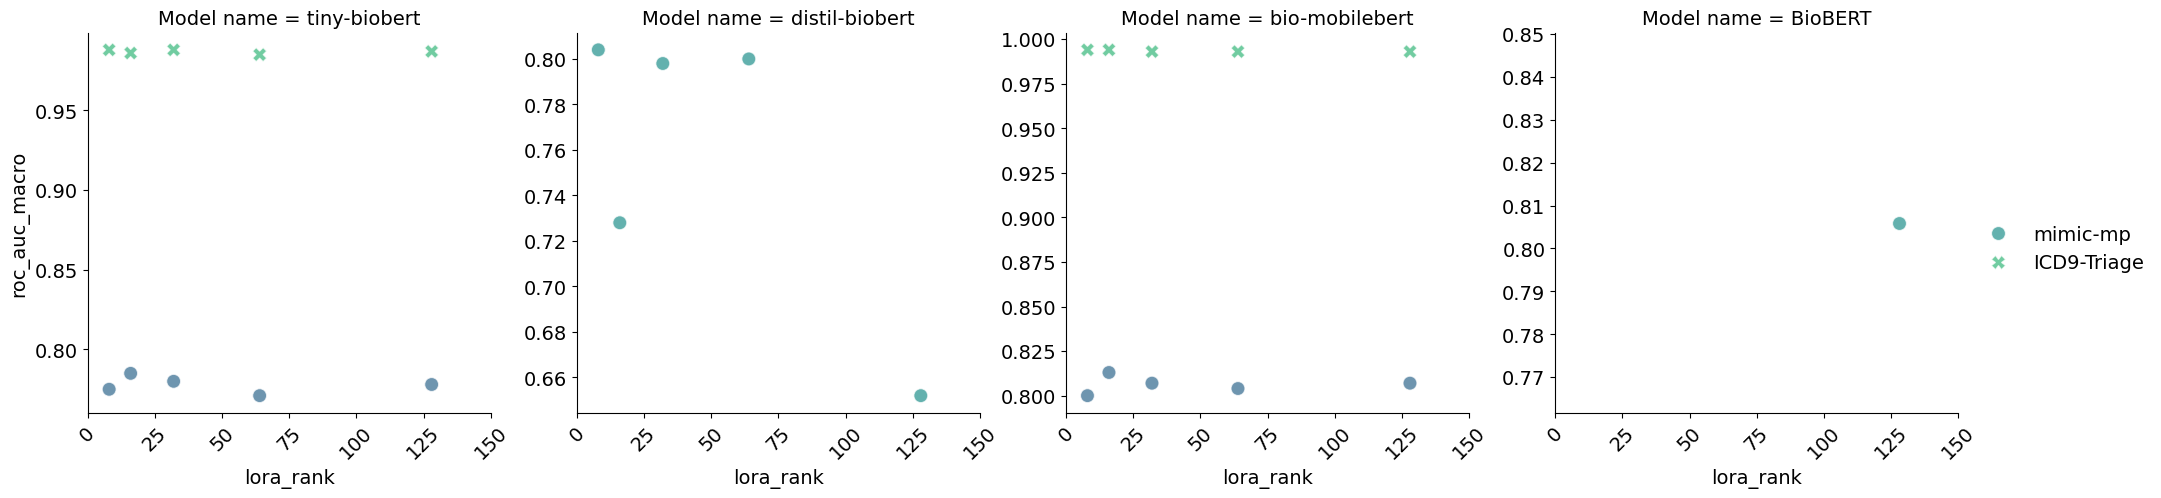

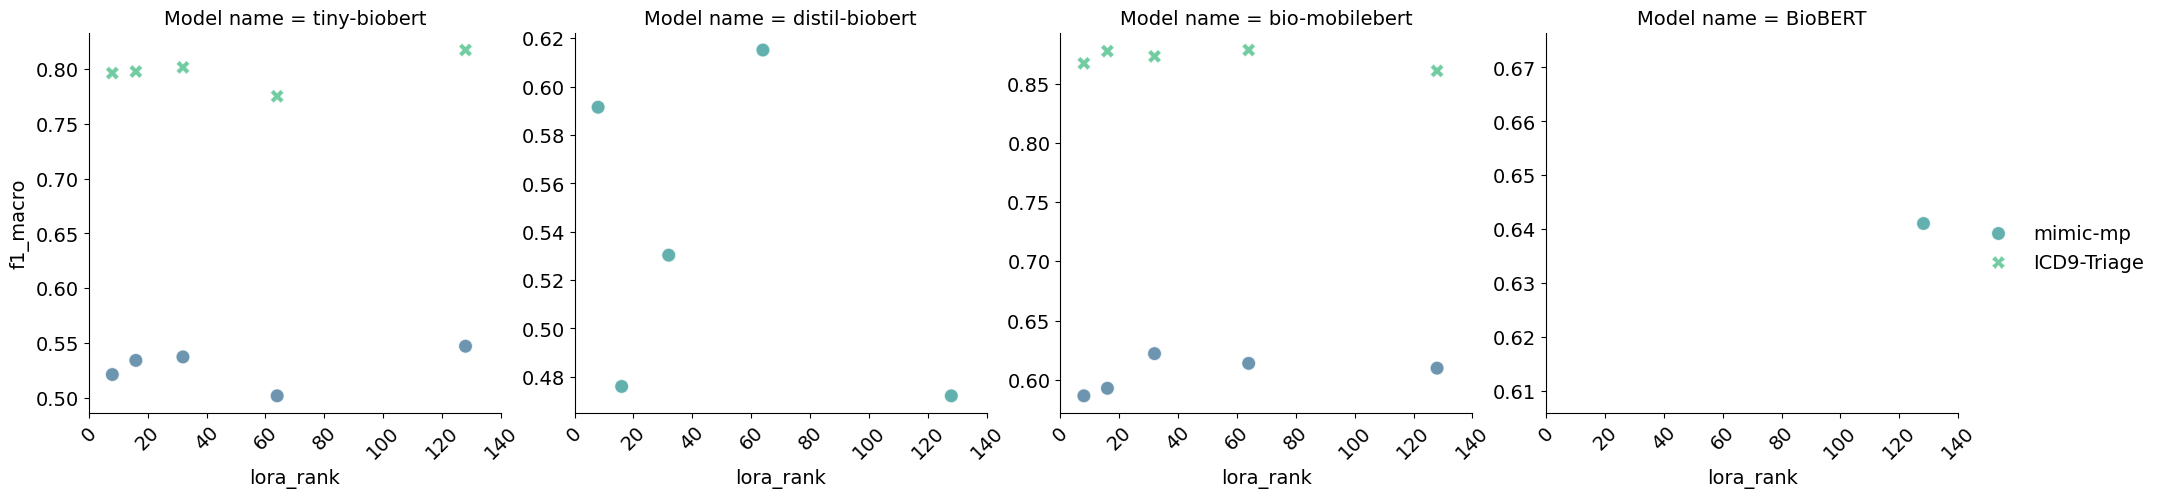

In [86]:
metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='Model name', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot, x='lora_rank', y=metric, style = 'task',
                     hue='task', palette='viridis', s=100, alpha=0.7,
                     )
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45)
    plt.savefig(f'{save_path}/{metric}_peft_methods_lora_rank.png', bbox_inches='tight')
    plt.show()


# NER tasks

In [143]:
ner_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,Full,0.930603,0.947615,0.857877,0.856037,0.864545,0.821867,0.821637,0.822097
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,IA3,0.830793,0.847326,0.454201,0.464756,0.444115,0.471903,0.499843,0.446920
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,LORA,0.905475,0.923514,0.732703,0.748841,0.717246,0.713018,0.730265,0.696567
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250,PREFIX_TUNING,0.818223,0.838363,0.445300,0.464257,0.427831,0.453597,0.493298,0.419810
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2012-NER,250,Full,0.906669,0.914063,0.848851,0.842254,0.859592,0.823431,0.809410,0.837946


In [144]:
ner_results_df["Model name"].unique()

array(['BioBERT', 'bio-mobilebert', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [145]:
peft_methods_to_plot = [ "IA3","LORA", "Full"]

In [148]:
plot_df = ner_results_df.loc[ner_results_df['few_shot_n'] > 200].copy()

plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)


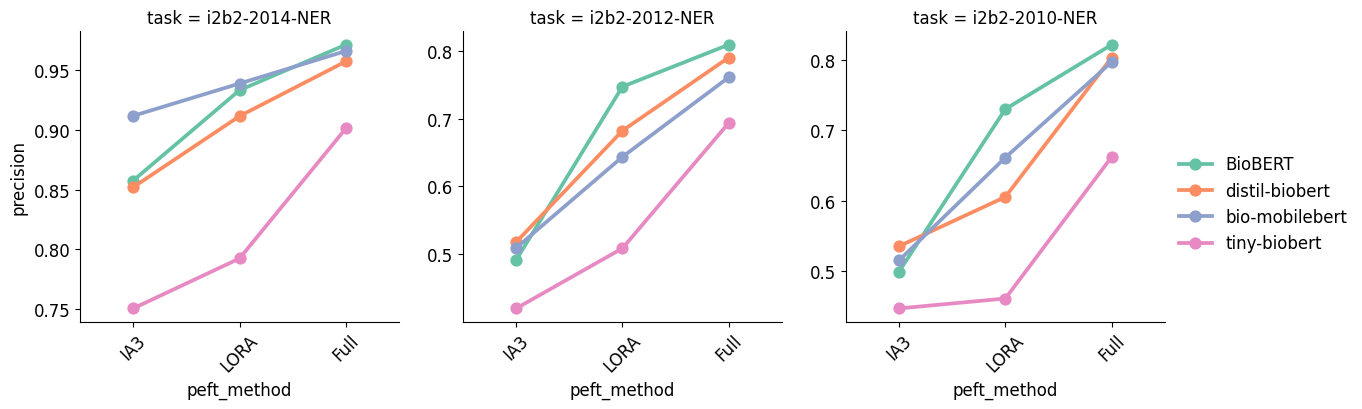

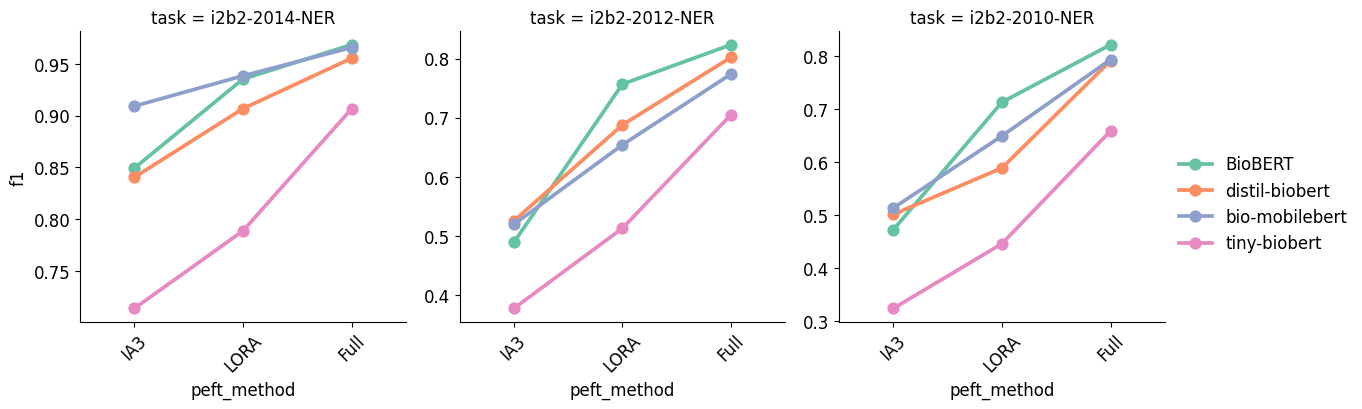

In [149]:
metrics = ['precision', 'f1']

  
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='Model name', 
                    order=peft_methods_to_plot, 
                    hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # plt.savefig(f'{save_path}/NER_{metric}_peft_methods.png', bbox_inches='tight')
    plt.show()

In [151]:
# make a latex table from this

ner_paper_results = plot_df.groupby(['Model name', 'peft_method', 'task'])['f1'].max().reset_index().pivot_table(index=['Model name', 'peft_method'],
                                                                                                        columns=['task',],
                                                                                                        values='f1').reset_index()
print(ner_paper_results.to_latex(
            caption = "PEFT results for NER tasks",
            label = "tab:peft-ner-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


# do same as above but for NER


\begin{table}[htp]
\centering
\caption{PEFT results for NER tasks}
\label{peft-ner-results}
\begin{tabular}{llrrr}
\toprule
    Model name & peft\_method &  i2b2-2010-NER &  i2b2-2012-NER &  i2b2-2014-NER \\
\midrule
       BioBERT &        Full &          0.822 &          0.823 &          0.969 \\
       BioBERT &         IA3 &          0.472 &          0.489 &          0.849 \\
       BioBERT &        LORA &          0.713 &          0.757 &          0.935 \\
bio-mobilebert &        Full &          0.794 &          0.774 &          0.966 \\
bio-mobilebert &         IA3 &          0.513 &          0.519 &          0.909 \\
bio-mobilebert &        LORA &          0.649 &          0.654 &          0.938 \\
distil-biobert &        Full &          0.792 &          0.802 &          0.955 \\
distil-biobert &         IA3 &          0.501 &          0.525 &          0.840 \\
distil-biobert &        LORA &          0.589 &          0.688 &          0.907 \\
  tiny-biobert &        Full &      

/tmp/ipykernel_39291/3866399420.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ner_paper_results.to_latex(


In [ ]:
# 

In [128]:
# plot for other paper
# peft_methods_to_plot = ["Full"]
# plot_df = ner_results_df.loc[ner_results_df['few_shot_n'] > 200].copy()

# paper_models = ['Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
#        'RoBERTa-mimic-note-two-epoch',"declutr-base"]

# plot_df = plot_df.loc[plot_df['Model name'].isin(
#     paper_models)] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
# plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
# plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1'], 
#                             ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)

# metrics = ['precision', 'f1']

  
# for metric in metrics:
    
#     fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
#     fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='Model name',                      
#                     palette='bright')
#     fg.add_legend()
#     # handles, labels = fg.axes[0,0].get_legend_handles_labels()
#     # fg.fig.legend(handles, labels)
#     # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
#     fg.set_xticklabels(rotation = 45)
#     # plt.savefig(f'{save_path}/NER_{metric}_peft_methods.png', bbox_inches='tight')
#     plt.show()

In [26]:
ner_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1,precision,recall
0,0,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-NER,250.0,Full,0.937673,0.843558,0.841821,0.852396
1,1,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-NER,250.0,LORA,0.920507,0.770119,0.767460,0.772798
2,2,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2012-NER,250.0,Full,0.914369,0.841927,0.835017,0.853659
3,3,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2012-NER,250.0,LORA,0.892563,0.791017,0.772709,0.813864
4,4,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2014-NER,250.0,Full,0.996175,0.962993,0.968270,0.957774
...,...,...,...,...,...,...,...,...,...,...
72,72,tiny-biobert,nlpie/tiny-biobert,i2b2-2012-NER,250.0,LORA,0.819310,0.605758,0.593652,0.618367
73,73,tiny-biobert,nlpie/tiny-biobert,i2b2-2012-NER,250.0,PREFIX_TUNING,0.840623,0.629934,0.604198,0.657959
74,74,tiny-biobert,nlpie/tiny-biobert,i2b2-2014-NER,250.0,Full,0.991380,0.915032,0.911765,0.918322
75,75,tiny-biobert,nlpie/tiny-biobert,i2b2-2014-NER,250.0,IA3,0.970329,0.713888,0.750330,0.680822


### Model comparison

In [24]:
models_of_interest

['roberta-base',
 'Bio_ClinicalBERT',
 'mimic-roberta-base',
 'bio-mobilebert',
 'distil-biobert']

In [35]:
# ner_results_df.query("task == @task")

### Can also look at averages across tasks

not sure if good idea or not, but may be useful to look at averages across tasks

In [ ]:
results_df = produce_results_table(logs_df, 
                                        metric = ["f1_macro","accuracy"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "few_shot_n", "peft_method"],
                                        tasks = ["icd9-triage-no-category-in-text","mimic-mp"],
                                        value_aggregate_method = "max",
                                        )

In [129]:
# Seq classification results



tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,0.946406,0.947013,0.874629,0.947013,...,1160.397217,41.188000,1.288,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
3,3,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,PREFIX_TUNING,0.723834,0.719653,0.282616,0.719653,...,905.988220,52.755001,1.650,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,Full,0.937581,0.938186,0.671258,0.938186,...,1541.651245,72.181999,2.257,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,IA3,0.897581,0.895860,0.284792,0.895860,...,1313.807373,84.699997,2.649,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,LORA,0.926791,0.925488,0.421195,0.925488,...,1333.473877,83.450996,2.610,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,PREFIX_TUNING,0.870140,0.868233,0.167140,0.868233,...,1241.261963,89.651001,2.804,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,Full,0.454473,0.434753,0.408146,0.434753,...,3420.683350,44.466000,1.390,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,IA3,0.396499,0.390572,0.288559,0.390572,...,2786.532471,54.585999,1.706,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765


#### random debugging

In [103]:
from scipy.special import softmax as sk_softmax
# load softmax from pytorch
from torch.nn.functional import softmax

In [104]:
faulty_logits =  [26443.322, 26029.15, 23799.176, 12593.839, 22744.002, 20037.562, 30538.14, 21639.273, 30558.88]

In [106]:
np.sum(sk_softmax(faulty_logits))

1.0000000000011509

In [119]:
import evaluate

In [84]:
# convert faulty logits to tensor
logits = torch.tensor(faulty_logits)

In [88]:
logits

tensor([26443.3223, 26029.1504, 23799.1758, 12593.8389, 22744.0020, 20037.5625,
        30538.1406, 21639.2734, 30558.8809])

In [87]:
sk_softmax(logits)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [86]:
softmax(logits)

/tmp/ipykernel_39749/3615344952.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(logits)


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [97]:
working_logits = [25719.342, 25567.707, 23205.53, 12138.746, 22023.115, 19547.37, 29444.035, 21317.316, 29743.26]

In [96]:
softmax(torch.tensor(working_logits))

/tmp/ipykernel_39749/2639681039.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor(working_logits))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [94]:
np.max(faulty_logits)

30558.88

In [93]:
working_logits

[25719.342,
 25567.707,
 23205.53,
 12138.746,
 22023.115,
 19547.37,
 29444.035,
 21317.316,
 29743.26]

In [107]:
from torchmetrics import AUROC

In [128]:
# faulty labels

faulty_labels = np.zeros_like(faulty_logits)
faulty_labels[5] = 1

In [181]:
auroc = AUROC(task =  "binary", threshold = 0.5)
multi_auroc = AUROC(task = "multiclass", num_classes=9)

In [118]:
faulty_logits

[26443.322,
 26029.15,
 23799.176,
 12593.839,
 22744.002,
 20037.562,
 30538.14,
 21639.273,
 30558.88]

In [117]:
auroc(torch.tensor((faulty_logits)), torch.tensor(faulty_labels))

/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


tensor(0.)

In [177]:
hf_roc_auc = evaluate.load("roc_auc", "multiclass")

In [123]:
faulty_scores = sk_softmax(faulty_logits)

In [125]:
faulty_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [124]:
faulty_scores

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.83405074e-10, 0.00000000e+00,
       9.99999999e-01])

In [130]:
hf_roc_auc.compute(references=faulty_labels,
                                            prediction_scores = faulty_scores,
                                            multi_class = 'ovr', 
                                            average = "macro")['roc_auc']

0.375

In [139]:
import numpy as np

# Open file 
data = []
with open('../faulty_logits.txt') as f:
  # Read lines
  lines = f.read().split('\n')

data = [d.split(',') for d in lines]
data = np.array(data, dtype=np.float32)
print(data)

[[26443.322 26029.15  23799.176 ... 30538.14  21639.273 30558.88 ]
 [25855.453 25518.928 23285.416 ... 29789.299 21231.01  29885.418]
 [26724.164 26196.896 24030.08  ... 30973.979 21752.494 30876.074]
 ...
 [20373.922 19027.521 18072.285 ... 24537.35  15531.233 23401.838]
 [28499.885 27426.361 25497.64  ... 33555.13  22613.291 32864.805]
 [24578.404 23902.756 22054.492 ... 28687.58  19786.752 28377.973]]


In [158]:

faulty_labels = np.random.randint(0, len(data[0]), size=len(data))


In [162]:
faulty_labels.max()

8

In [144]:
faulty_labels.shape

(43000, 9)

In [170]:
faulty_scores = sk_softmax(data, axis = -1)

In [171]:
faulty_scores

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.831747e-10,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.803471e-42,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 3.026805e-43],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [172]:
faulty_scores.shape

(43000, 9)

In [174]:
faulty_labels

(43000,)

In [186]:
torch.tensor(faulty_scores).shape

torch.Size([43000, 9])

In [187]:
multi_auroc(torch.tensor(faulty_scores), torch.tensor(faulty_labels))

tensor(0.5000)

In [178]:
hf_roc_auc.compute(references=faulty_labels,
                    prediction_scores = faulty_scores,
                    multi_class = 'ovr', 
                    average = "macro")['roc_auc']

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes